# Yelp Reviews: Stars on Reviews - LightGBM GPU
## Optuna Hyperparameter Optimization

## Set Up Environment, Read Data, Split Train/Test Sets

In [ ]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/Yelp_Reviews/ML/Classification/lightGBM/

/content/drive/MyDrive/Yelp_Reviews/ML/Classification/lightGBM


In [ ]:
# Clone lightGBM
!git clone --recursive https://github.com/Microsoft/LightGBM

Cloning into 'LightGBM'...
remote: Enumerating objects: 27556, done.
remote: Counting objects: 100% (3712/3712), done.
remote: Compressing objects: 100% (379/379), done.
remote: Total 27556 (delta 3496), reused 3382 (delta 3326), pack-reused 23844
Receiving objects: 100% (27556/27556), 19.67 MiB | 6.90 MiB/s, done.
Resolving deltas: 100% (20445/20445), done.
Checking out files: 100% (521/521), done.
Submodule 'include/boost/compute' (https://github.com/boostorg/compute) registered for path 'external_libs/compute'
Submodule 'eigen' (https://gitlab.com/libeigen/eigen.git) registered for path 'external_libs/eigen'
Submodule 'external_libs/fast_double_parser' (https://github.com/lemire/fast_double_parser.git) registered for path 'external_libs/fast_double_parser'
Submodule 'external_libs/fmt' (https://github.com/fmtlib/fmt.git) registered for path 'external_libs/fmt'
Cloning into '/content/drive/MyDrive/Yelp_Reviews/ML/Classification/lightGBM/LightGBM/external_libs/compute'...
remote: Enum

In [ ]:
%cd /content/drive/MyDrive/Yelp_Reviews/ML/Classification/lightGBM/LightGBM/

!mkdir build

/content/drive/MyDrive/Yelp_Reviews/ML/Classification/lightGBM/LightGBM


In [ ]:
# Compile
!cmake -DUSE_GPU=1 
!make -j$(nproc)

CMake Warning:
  No source or binary directory provided.  Both will be assumed to be the
  same as the current working directory, but note that this warning will
  become a fatal error in future CMake releases.


-- The C compiler identification is GNU 7.5.0
-- The CXX compiler identification is GNU 7.5.0
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Check for working C compiler: /usr/bin/cc - skipped
-- Detecting C compile features
-- Detecting C compile features - done
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Check for working CXX compiler: /usr/bin/c++ - skipped
-- Detecting CXX compile features
-- Detecting CXX compile features - done
-- Found OpenMP_C: -fopenmp (found version "4.5") 
-- Found OpenMP_CXX: -fopenmp (found version "4.5") 
-- Found OpenMP: TRUE (found version "4.5")  
-- Looking for CL_VERSION_2_2
-- Looking for CL_VERSION_2_2 - found
-- Found OpenCL: /usr/lib/x86_64-linux-gnu/libOpenCL.so (found ver

In [ ]:
# Install needed packages
!sudo apt-get -y install python-pip
!sudo -H pip install setuptools numpy pandas scikit-learn sklearn joblib optuna gensim==3.8.3 datetime plotly matplotlib seaborn -U

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following additional packages will be installed:
  libpython-all-dev python-all python-all-dev python-asn1crypto
  python-cffi-backend python-crypto python-cryptography python-dbus
  python-enum34 python-gi python-idna python-ipaddress python-keyring
  python-keyrings.alt python-pip-whl python-pkg-resources python-secretstorage
  python-setuptools python-six python-wheel python-xdg
Suggested packages:
  python-crypto-doc python-cryptography-doc python-cryptography-vectors
  python-dbus-dbg python-dbus-doc python-enum34-doc python-gi-cairo
  gnome-keyring libkf5wallet-bin gir1.2-gnomekeyring-1.0 python-fs
  python-gdata python-keyczar python-secretstorage-doc python-setuptools-doc
The following NEW packages will be installed:
  libpython-all-dev pytho

In [ ]:
%cd /content/drive/MyDrive/Yelp_Reviews/ML/Classification/lightGBM/LightGBM/python-package/

# Compile for GPU
!sudo python3 setup.py install --precompile --gpu

/content/drive/MyDrive/Yelp_Reviews/ML/Classification/lightGBM/LightGBM/python-package
running install
/usr/local/lib/python3.7/dist-packages/setuptools/command/install.py:37: SetuptoolsDeprecationWarning: setup.py install is deprecated. Use build and pip and other standards-based tools.
  setuptools.SetuptoolsDeprecationWarning,
running build
running build_py
creating build
creating build/lib
creating build/lib/lightgbm
copying lightgbm/__init__.py -> build/lib/lightgbm
copying lightgbm/basic.py -> build/lib/lightgbm
copying lightgbm/callback.py -> build/lib/lightgbm
copying lightgbm/compat.py -> build/lib/lightgbm
copying lightgbm/dask.py -> build/lib/lightgbm
copying lightgbm/engine.py -> build/lib/lightgbm
copying lightgbm/libpath.py -> build/lib/lightgbm
copying lightgbm/plotting.py -> build/lib/lightgbm
copying lightgbm/sklearn.py -> build/lib/lightgbm
running egg_info
creating lightgbm.egg-info
writing lightgbm.egg-info/PKG-INFO
writing dependency_links to lightgbm.egg-info/depe

In [ ]:
import os
import random
import numpy as np
import warnings
import pandas as pd
from datetime import datetime, timedelta
from timeit import default_timer as timer
import gensim
from gensim.models import Word2Vec, KeyedVectors
from gensim import models
import multiprocessing
import pickle
import joblib
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from lightgbm import LGBMClassifier
import optuna
from optuna import Trial
from sklearn.metrics import log_loss, accuracy_score, recall_score, precision_score
from sklearn.metrics import f1_score classification_report, confusion_matrix
import plotly.offline as py
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings('ignore')
optuna.logging.set_verbosity(optuna.logging.WARNING) # use INFO to see progress
my_dpi = 96

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 348 kB 5.2 MB/s 
     |████████████████████████████████| 81 kB 9.9 MB/s 
     |████████████████████████████████| 209 kB 50.7 MB/s 
     |████████████████████████████████| 78 kB 7.2 MB/s 
     |████████████████████████████████| 49 kB 4.6 MB/s 
     |████████████████████████████████| 147 kB 64.0 MB/s 
     |████████████████████████████████| 112 kB 64.8 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=56dd42a8b4d2f7da5542a28545dd9f550a9881cd177213bc5eb8f56324301932
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip
     |████████████████████████████████| 1.8 MB 5.2 MB/s 
     |████████████████████████████████| 181 kB 53.7 MB/s 
     |████████████████████████████████| 158 kB 48.1 MB/s 
     |███████████████████████████████

In [ ]:
print('CUDA and NVIDIA GPU Information')
!/usr/local/cuda/bin/nvcc --version
!nvidia-smi
print('\n')
cores = multiprocessing.cpu_count()
print('Number of cores:', cores)

CUDA and NVIDIA GPU Information
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0
Tue Sep  6 01:37:43 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|            

In [ ]:
# Set seed 
seed_value = 42
os.environ['YelpReviews_ML'] = str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)

In [ ]:
%cd /content/drive/MyDrive/Yelp_Reviews/Data/

/content/drive/MyDrive/Yelp_Reviews/Data


In [ ]:
# Read tokenized reviews with stars filtered to 1, 2 and 5
df = pd.read_parquet('YelpReviews_NLP_125stars_tokenized.parquet')
print('Number of rows and columns:', df.shape)
df.head()

Number of rows and columns: (1541486, 2)


stars_reviews                                        cleanReview
index                                                                  
2                5.0  [wonderful, place, get, lunch, staff, friendly...
3                5.0  [dedicated, loving, memory, gary, feldman, gre...
5                5.0  [love, place, everything, menu, delicious, lik...
7                5.0  [truely, hidden, gem, place, greatest, buffalo...
9                5.0  [seriously, great, fresh, fantastic, food, spo...

In [ ]:
# Process format of reviews for word2vec
df["cleanReview"]= [[f'"{j}"' for j in i] for i in df["cleanReview"]]
df.head()

stars_reviews                                        cleanReview
index                                                                  
2                5.0  ["wonderful", "place", "get", "lunch", "staff"...
3                5.0  ["dedicated", "loving", "memory", "gary", "fel...
5                5.0  ["love", "place", "everything", "menu", "delic...
7                5.0  ["truely", "hidden", "gem", "place", "greatest...
9                5.0  ["seriously", "great", "fresh", "fantastic", "...

In [ ]:
# Recode to binary
df['stars_reviews'].mask(df['stars_reviews'] == 1, 0, inplace=True)
df['stars_reviews'].mask(df['stars_reviews'] == 2, 0, inplace=True)
df['stars_reviews'].mask(df['stars_reviews'] == 5, 1, inplace=True)

print('Number of reviews per group:')
df[['stars_reviews']].value_counts() 

Number of reviews per group:


stars_reviews
0.0              770743
1.0              770743
dtype: int64

In [ ]:
# Shuffle and sample 1 & 2 star reviews
df1 = df[df.stars_reviews==0]
df1 = shuffle(df1)
df1 = df1.sample(n=414937)

In [ ]:
# Shuffle and sample 5 star reviews
df2 = df[df.stars_reviews==1]
df2 = shuffle(df2)
df2 = df2.sample(n=414937)

# Concat with 1 and 2 star reviews
df = pd.concat([df1, df2])
df = shuffle(df)

del df1, df2

df.shape

(829874, 2)

In [ ]:
# Set up label and features
label = df[['stars_reviews']]
features = df.cleanReview

## Word2vec - Reviews: 50epochs

In [ ]:
%cd /content/drive/MyDrive/Yelp_Reviews/Data/word2vec_models/

/content/drive/MyDrive/Yelp_Reviews/Data/word2vec_models


In [ ]:
# Load model
word2vec_path = 'gensim_w2vModel_review125_50epochs.bin'
model = models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

In [ ]:
# Save embedded word vector space
wv = model.wv
print(len(wv.vocab), 'unique words in the dataset.')

373847 unique words in the dataset.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning:

Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).



In [ ]:
# Creating Mean Word Embeddings using Mean Embedding Vectorizer class
class W2vVectorizer(object):
    """
    This class is used to provide mean word vectors for text. 
    The transform function generates mean vectors in model pipelines.
    The class has both fit & transform functions for use in a sklearn Pipeline.
    """
    
    def __init__(self, w2v):
        self.w2v = w2v
        
        # If using GloVe, the model is in a dictionary format
        if isinstance(w2v, dict):
            if len(w2v) == 0:
                self.dimensions = 0
            else:
                self.dimensions = len(w2v[next(iter(w2v))])
        # Otherwise, using gensim keyed vector
        else:
            self.dimensions = w2v.vector_size
    
    # Implement a fit method required for sklearn Pipeline.
    def fit(self, X, y):
        return self

    def transform(self, X):
        """
        Generates a w2v vector for a set of tokens by taking 
        the mean of each token in the review.
        """
        return np.array([
            np.mean([self.w2v[w] for w in words if w in self.w2v]
                    or [np.zeros(self.dimensions)], axis=0) for words in X])

In [ ]:
print('Pipeline for Word2Vec:')
pl  = Pipeline([('W2vVectorizer', W2vVectorizer(wv))])
pl

Pipeline for Word2Vec:


Pipeline(steps=[('W2vVectorizer',
                 <__main__.W2vVectorizer object at 0x7f4882bff850>)])

In [ ]:
def train_model_for_study(features, label, model):
    X_train, X_test, y_train, y_test = train_test_split(
        features, 
        label, 
        test_size=0.2, 
        stratify=label,
        random_state=seed_value)

    # Vectorize
    X_train = pl.fit_transform(X_train)
    X_test = pl.fit_transform(X_test)
    
    # Start timer for each trial
    start = timer()

    # Fit model
    model.fit(
        X_train, 
        y_train.values.ravel(),
        eval_set=[(X_test, y_test.values.ravel())])
    run_time = timer() - start

    # Predictions
    y_pred_val = model.predict_proba(X_test)
    cv_scores = log_loss(y_test, y_pred_val)     
    print('- Validation logloss:', np.mean(cv_scores))  

    return np.mean(cv_scores)       

### 100 Trials

In [ ]:
%cd /content/drive/MyDrive/Yelp_Reviews/Models/ML/lightGBM/ReviewStars/Model_PKL/

In [ ]:
def lgb_hpo(trial):
    """
    Objective function to tune a `LGBMClassifier` model.
    """
    joblib.dump(study, 'lightGBM_Optuna_100_GPU_balancedSizeSentiment.pkl')

    # Define parameter grid
    params_lgb_optuna = {
        'random_state': seed_value,
        'device_type':'gpu',
        'objective': 'binary',
        'metric': 'binary_logloss',
        'boosting_type': 'gbdt',
        'n_estimators': trial.suggest_int('n_estimators', 100, 500, step=10),
        'learning_rate': trial.suggest_float('learning_rate', 1e-6, 0.1),
        'num_leaves': trial.suggest_int('num_leaves', 100, 1000, step=20),
        'bagging_freq': trial.suggest_int('bagging_freq', 3, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 0.95),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 0.9),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 1e-1, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 1e-1,  log=True),
        'min_gain_to_split': trial.suggest_float('min_gain_to_split', 0, 15),
        'min_child_samples': trial.suggest_int('min_child_samples', 100, 500, 
                                               step=10),       
        'verbosity': -1}
    
    # Define model
    model = LGBMClassifier(**params_lgb_optuna, early_stopping_rounds=150)

    return train_model_for_study(features, label, model)

In [ ]:
# Begin HPO trials 
# Start timer for experiment
start_time = datetime.now()
print('%-20s %s' % ('Start Time', start_time))
if os.path.isfile('lightGBM_Optuna_100_GPU_balancedSizeSentiment.pkl'):
    study = joblib.load('lightGBM_Optuna_100_GPU_balancedSizeSentiment.pkl')
else:
    study = optuna.create_study(direction='minimize')
study.optimize(lgb_hpo, n_trials=2)

# End timer for experiment
end_time = datetime.now()
print('%-20s %s' % ('Start Time', start_time))
print('%-20s %s' % ('End Time', end_time))
print(str(timedelta(seconds=(end_time-start_time).seconds)))
print('\n')
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)
print('Lowest LogLoss', study.best_value)

Start Time           2022-05-13 19:09:27.660707
[LightGBM] [Warning] lambda_l2 is set=6.004088321275922e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.004088321275922e-05
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] early_stopping_round is set=150, early_stopping_rounds=150 will be ignored. Current value: early_stopping_round=150
[LightGBM] [Warning] lambda_l1 is set=5.541795033541325e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.541795033541325e-08
[LightGBM] [Warning] min_gain_to_split is set=0.7797243481269726, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7797243481269726
- Validation logloss: 0.6474538317163476
- Validation logloss: 0.15613514660760613
Start Time           2022-05-13 19:09:27.660707
End Time             2022-05-13 19:14:25.347940
0:04:57


Number of finished trials: 100
Best trial: {'n_estimators': 490, 'learning_rate': 0

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/Yelp_Reviews/Models/ML/lightGBM/ReviewStars/trialOptions/

In [ ]:
# Output from HPO trials
trials_df = study.trials_dataframe()
trials_df.rename(columns={'number': 'iteration'}, inplace=True)
trials_df.rename(columns={'value': 'logloss'},inplace=True)
trials_df.rename(columns={'params_bagging_freq': 'bagging_freq'}, inplace=True)
trials_df.rename(columns={'params_colsample_bytree': 'colsample_bytree'}, 
                 inplace=True)
trials_df.rename(columns={'params_lambda_l1': 'lambda_l1'}, inplace=True)
trials_df.rename(columns={'params_lambda_l2': 'lambda_l2'}, inplace=True)
trials_df.rename(columns={'params_learning_rate': 'learning_rate'}, 
                 inplace=True)
trials_df.rename(columns={'params_max_depth': 'max_depth'}, inplace=True)
trials_df.rename(columns={'params_min_child_samples': 'min_child_samples'}, 
                 inplace=True)
trials_df.rename(columns={'params_min_gain_to_split': 'min_gain_to_split'}, 
                 inplace=True)
trials_df.rename(columns={'params_n_estimators': 'n_estimators'}, inplace=True)
trials_df.rename(columns={'params_num_leaves': 'num_leaves'}, inplace=True)
trials_df.rename(columns={'params_subsample': 'subsample'}, inplace=True)
trials_df = trials_df.sort_values('logloss', ascending=True)
trials_df = trials_df[trials_df['logloss'].notna()]
print(trials_df)  

# Write processed data to csv
trials_df.to_csv('lightGBM_Optuna_100_GPU_balancedSizeSentiment.csv', 
                 index=False)

    iteration   logloss             datetime_start          datetime_complete  \
96         96  0.155430 2022-05-13 18:54:42.680881 2022-05-13 18:57:38.221153   
88         88  0.155467 2022-05-13 18:30:48.531839 2022-05-13 18:33:47.343464   
49         49  0.155661 2022-05-13 16:52:01.442298 2022-05-13 16:54:25.113981   
90         90  0.155664 2022-05-13 18:36:56.747928 2022-05-13 18:39:54.208059   
95         95  0.155693 2022-05-13 18:51:50.018872 2022-05-13 18:54:42.680662   
..        ...       ...                        ...                        ...   
78         78  0.686511 2022-05-13 17:56:29.292496 2022-05-13 17:58:48.510538   
55         55  0.691049 2022-05-13 17:05:57.807068 2022-05-13 17:08:25.512981   
4           4  0.692417 2022-05-13 15:22:17.422076 2022-05-13 15:24:00.192281   
15         15  0.692560 2022-05-13 15:43:07.067983 2022-05-13 15:45:04.468038   
89         89  0.692655 2022-05-13 18:33:47.343673 2022-05-13 18:36:56.747661   

                 duration  

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/Yelp_Reviews/Models/ML/lightGBM/ReviewStars/Model_Explanations/

In [ ]:
# Plot_optimization_history: shows the scores from all trials as well as the best score so far at each point.
fig = optuna.visualization.plot_optimization_history(study)
py.plot(fig, filename='optimizationHistory_lightGBM_Optuna_100_GPU_balancedSizeSentiment.html')
fig.show()

In [ ]:
# Plot_parallel_coordinate: interactively visualizes the hyperparameters and scores
fig = optuna.visualization.plot_parallel_coordinate(study)
py.plot(fig, filename='parallelCoordinate_lightGBM_Optuna_100_GPU_balancedSizeSentiment.html')
fig.show()

In [ ]:
# plot_slice: shows the change of the hyperparamters space over the search. 
fig = optuna.visualization.plot_slice(study)
py.plot(fig, filename='slice_lightGBM_Optuna_100_GPU_balancedSizeSentiment.html')
fig.show()

In [ ]:
# Plot_contour: plots parameter interactions on an interactive chart. You can choose which hyperparameters you would like to explore.
fig = optuna.visualization.plot_contour(study, params=['num_leaves', 
                                                       'max_depth', 
                                                       'subsample', 
                                                       'learning_rate'])
py.plot(fig, filename='contour_lightGBM_Optuna_100_GPU_balancedSizeSentiment.html')
fig.show()

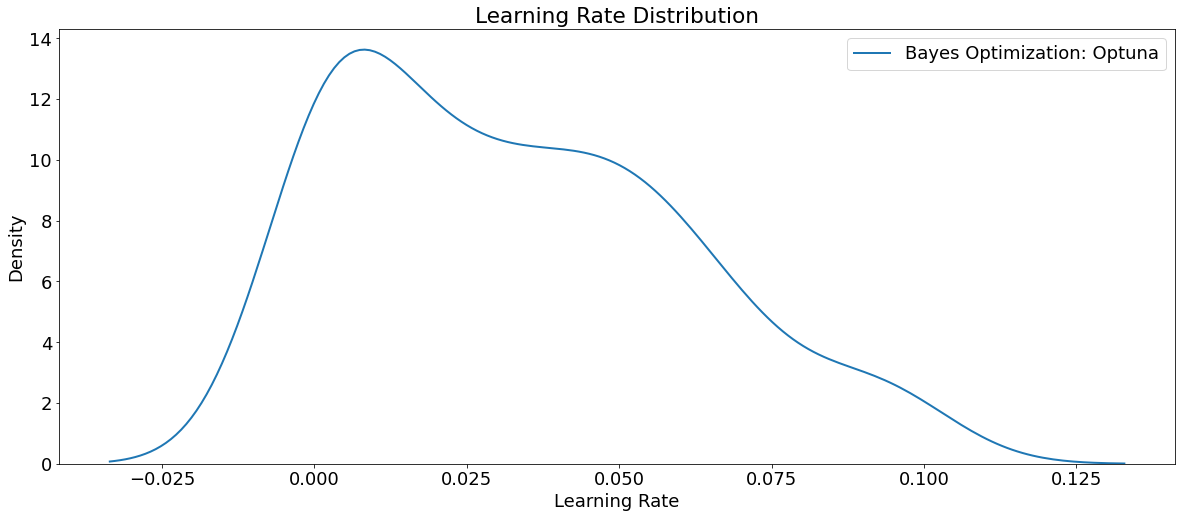

In [ ]:
# Density plots of the learning rate distributions 
plt.figure(figsize=(20,8))
plt.rcParams['font.size'] = 18
sns.kdeplot(trials_df['learning_rate'], label='Bayes Optimization: Optuna', 
            linewidth=2)
plt.legend(loc=1)
plt.xlabel('Learning Rate'); plt.ylabel('Density'); 
plt.title('Learning Rate Distribution');
plt.show()

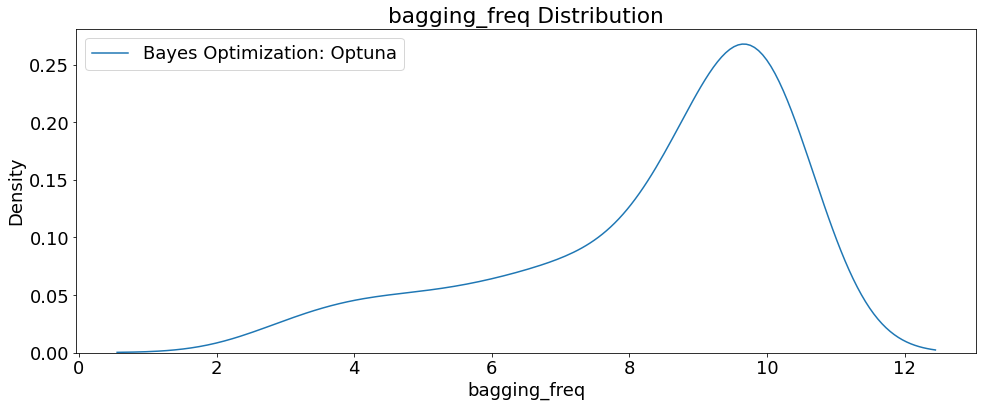

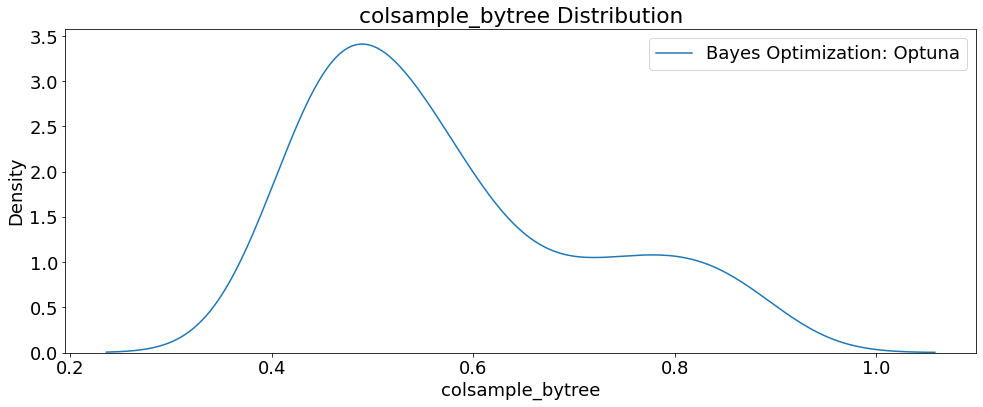

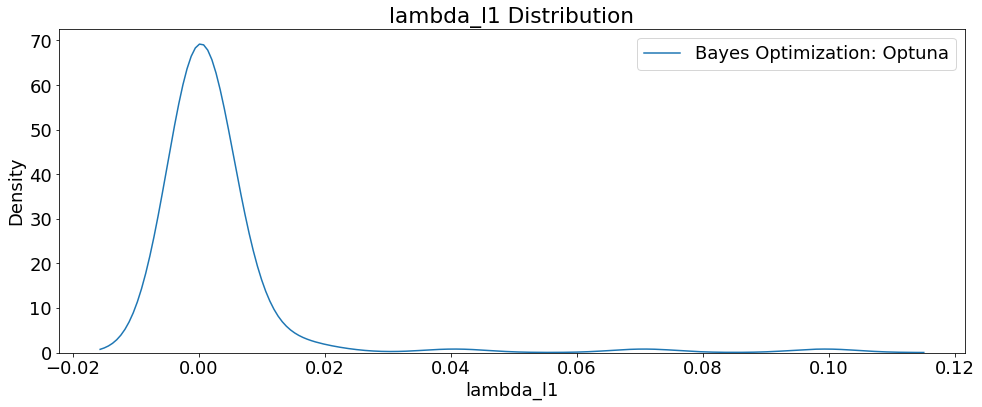

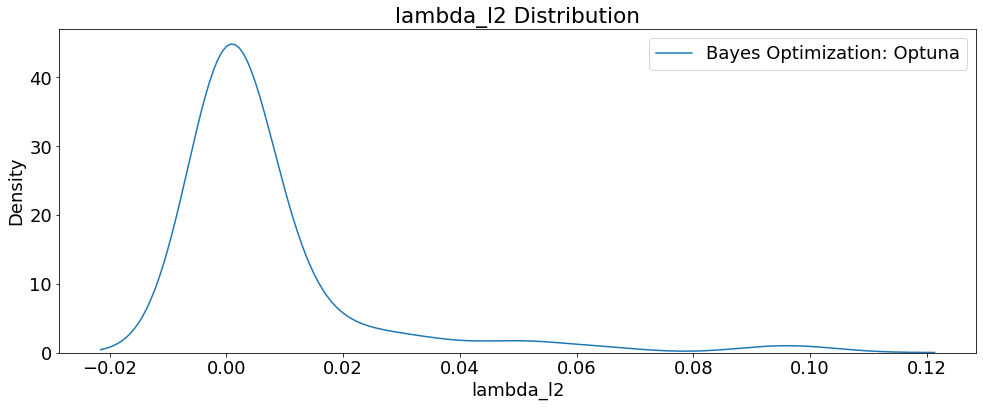

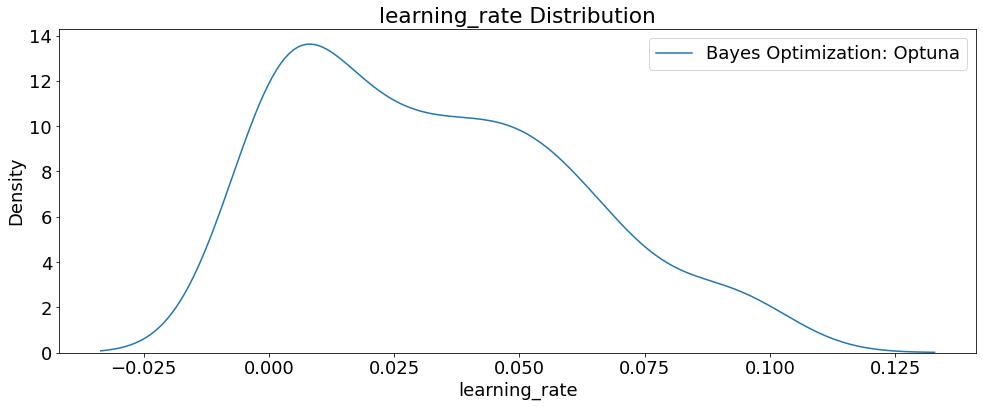

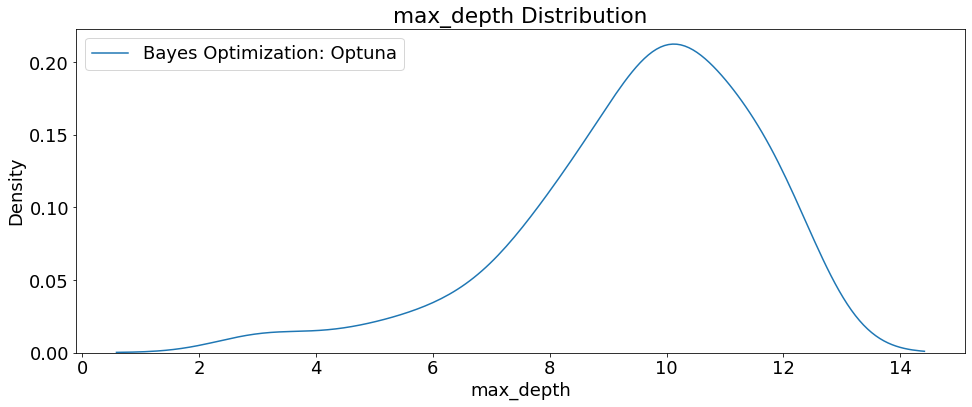

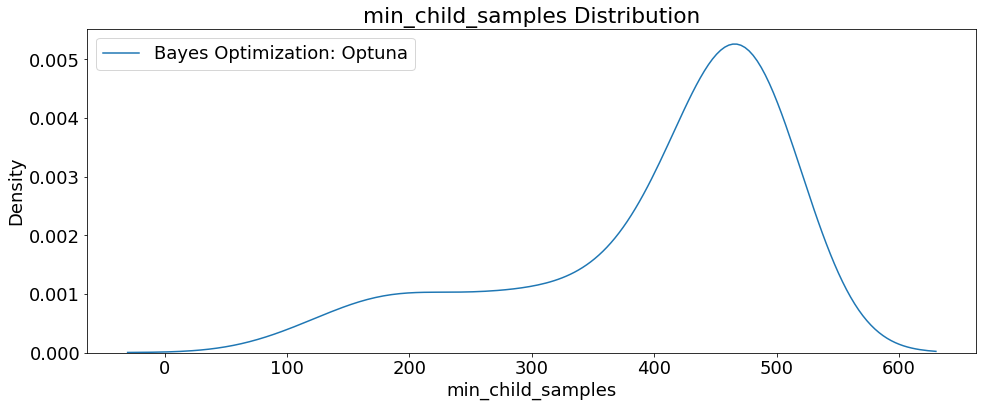

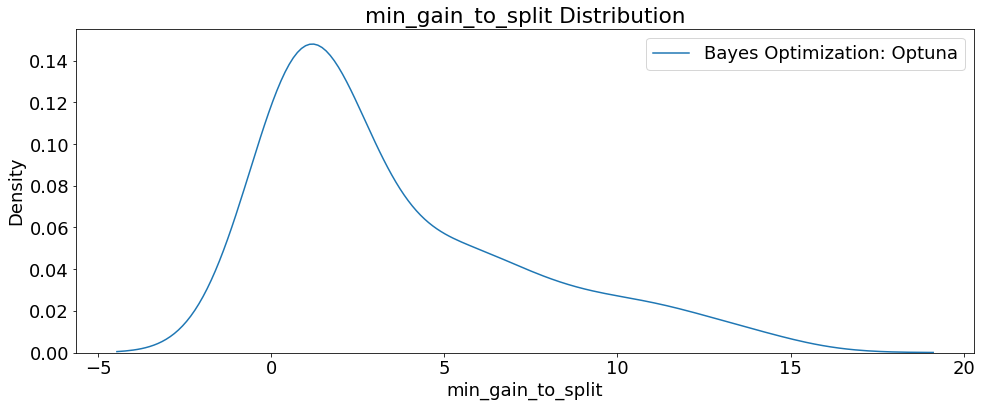

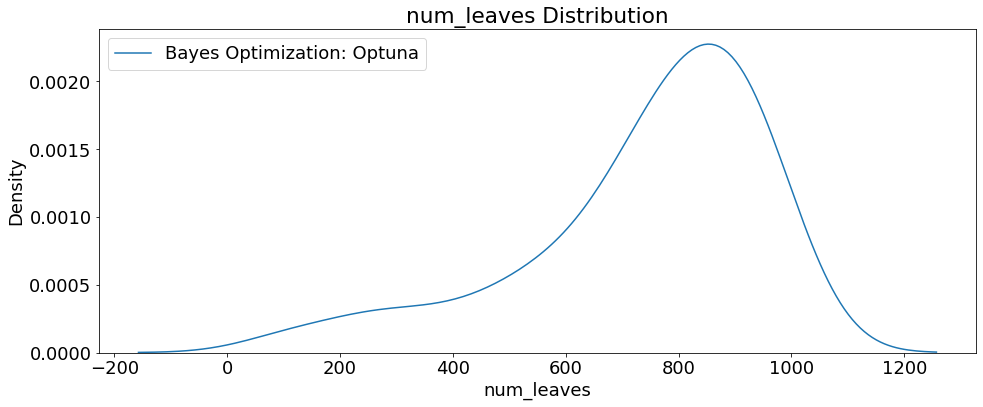

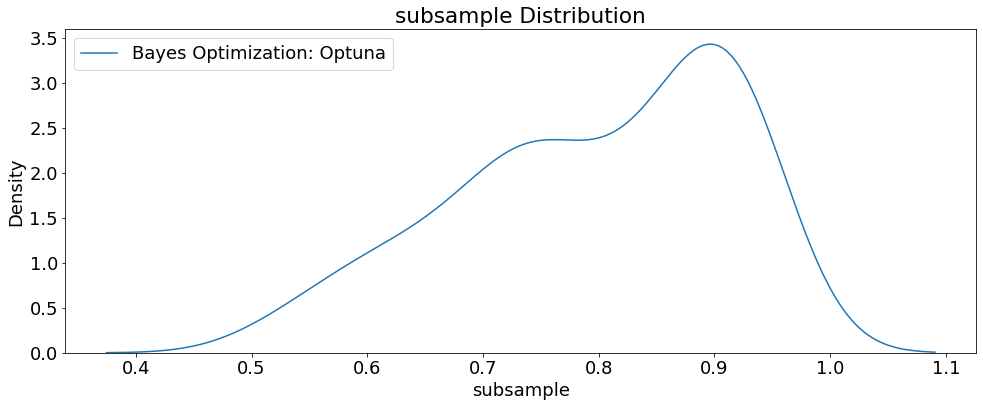

In [ ]:
# Create plots of Hyperparameters that are numeric 
for i, hpo in enumerate(trials_df.columns):
    if hpo not in ['iteration', 'logloss', 'datetime_start', 'datetime_complete',
                   'duration','n_estimators', 'state']:
        plt.figure(figsize=(14,6))
        # Plot the bayes search distribution
        if hpo != 'loss':
            sns.kdeplot(trials_df[hpo], label='Bayes Optimization: Optuna')
            plt.legend(loc=0)
            plt.title('{} Distribution'.format(hpo))
            plt.xlabel('{}'.format(hpo)); plt.ylabel('Density')
            plt.tight_layout()
            plt.show()

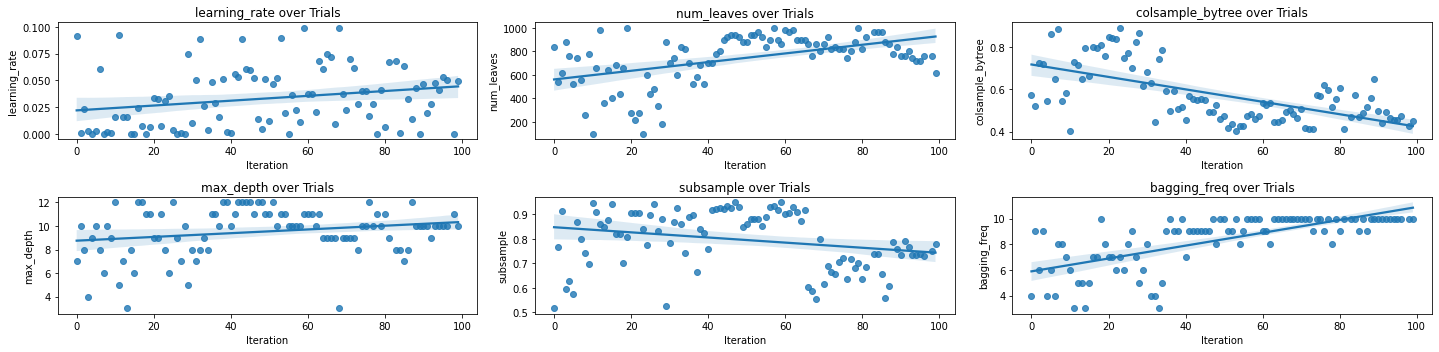

In [ ]:
# Plot quantitative hyperparameters
fig, axs = plt.subplots(2, 3, figsize=(20,5))
i = 0
axs = axs.flatten()
for i, hpo in enumerate(['learning_rate', 'num_leaves', 'colsample_bytree', 
                         'max_depth', 'subsample', 'bagging_freq']):
  # Scatterplot
  sns.regplot('iteration', hpo, data=trials_df, ax=axs[i]) 
  axs[i].set(xlabel='Iteration', ylabel='{}'.format(hpo),  
             title='{} over Trials'.format(hpo))
plt.tight_layout()
plt.show()

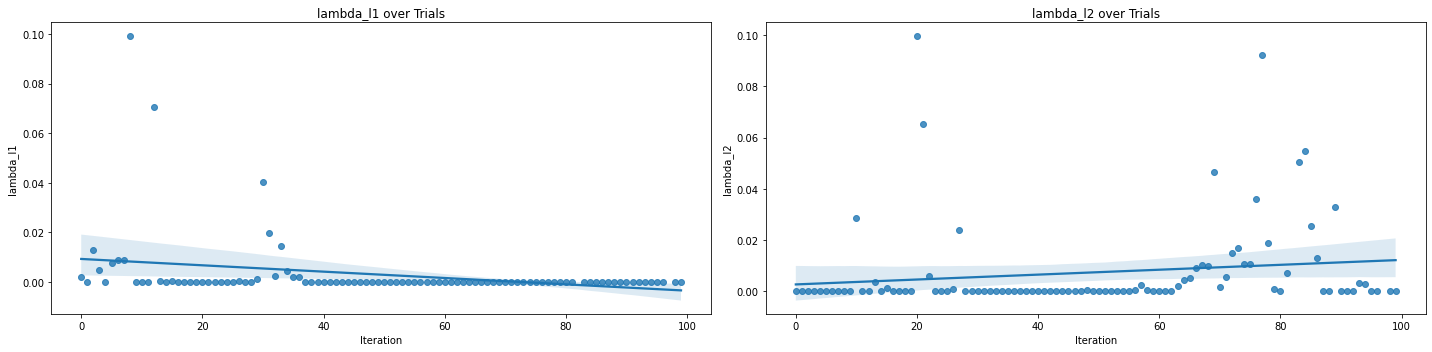

In [ ]:
# Scatterplot of regularization hyperparameters
fig, axs = plt.subplots(1, 2, figsize=(20,5))
i = 0
for i, hpo in enumerate(['lambda_l1', 'lambda_l2']):
  # Scatterplot
  sns.regplot('iteration', hpo, data=trials_df, ax=axs[i])
  axs[i].set(xlabel='Iteration', ylabel='{}'.format(hpo), 
             title='{} over Trials'.format(hpo))
plt.tight_layout()
plt.show()

In [ ]:
# Visualize parameter importances
fig = optuna.visualization.plot_param_importances(study)
py.plot(fig, filename='paramImportance_lightGBM_Optuna_100_GPU_balancedSizeSentiment.html')
fig.show()

In [ ]:
# Visualize empirical distribution function
fig = optuna.visualization.plot_edf(study)
py.plot(fig, filename='edf_lightGBM_Optuna_100_GPU_balancedSizeSentiment.html')
fig.show()

In [ ]:
# Arrange best parameters to fit model for model metrics
params = study.best_params   
params['random_state'] = seed_value
params['metric'] = 'binary_error'
params

{'bagging_freq': 10,
 'colsample_bytree': 0.4757810009639875,
 'lambda_l1': 1.705801617730491e-08,
 'lambda_l2': 6.230256501405558e-05,
 'learning_rate': 0.05021079866201762,
 'max_depth': 10,
 'metric': 'binary_error',
 'min_child_samples': 440,
 'min_gain_to_split': 0.7203173054362948,
 'n_estimators': 490,
 'num_leaves': 760,
 'random_state': 42,
 'subsample': 0.729486406738026}

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/Yelp_Reviews/Models/ML/lightGBM/ReviewStars/Model_PKL/

In [ ]:
# Set up target and features
label = df[['stars_reviews']]
features = df.cleanReview

# Partition data for train/test 
X_train, X_test, y_train, y_test = train_test_split(features, label,
                                                    test_size=0.2, 
                                                    stratify=label)

In [ ]:
# Vectorize reviews in train/test sets
X_train = pl.fit_transform(X_train)
X_test = pl.fit_transform(X_test)

In [ ]:
# Re-create the best model and train on the training data
best_model = LGBMClassifier(**params, verbosity=-1)

# Fit the model
best_model.fit(X_train, y_train)

# Save model
Pkl_Filename = 'lightGBM_HPO_Optuna_trials100_GPU_balancedSizeSentiment.pkl'  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(best_model, file)

# =============================================================================
# # To load saved model
# model = joblib.load('lightGBM_HPO_Optuna_trials100_GPU_balancedSizeSentiment.pkl')
# print(model)
# =============================================================================

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



[LightGBM] [Warning] lambda_l2 is set=6.230256501405558e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.230256501405558e-05
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] lambda_l1 is set=1.705801617730491e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.705801617730491e-08
[LightGBM] [Warning] min_gain_to_split is set=0.7203173054362948, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7203173054362948


In [ ]:
print('Results from lightGBM HPO Optuna 100 GPU trials:')
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)
print('\n')
print('Classification Report: Train')
clf_rpt = classification_report(y_train, y_train_pred)
print(clf_rpt)
print('\n')
print('Confusion matrix: Train')
print(confusion_matrix(y_train, y_train_pred))
print('\n')
print('Classification Report: Test')
clf_rpt = classification_report(y_test, y_test_pred)
print(clf_rpt)
print('\n')
print('Confusion matrix: Test')
print(confusion_matrix(y_test, y_test_pred))
print('\n')
print('Accuracy score: train: %.3f, test: %.3f' % (
        accuracy_score(y_train, y_train_pred),
        accuracy_score(y_test, y_test_pred)))
print('Precision score: train: %.3f, test: %.3f' % (
        precision_score(y_train, y_train_pred),
        precision_score(y_test, y_test_pred)))
print('Recall score: train: %.3f, test: %.3f' % (
        recall_score(y_train, y_train_pred),
        recall_score(y_test, y_test_pred)))
print('F1 score: train: %.3f, test: %.3f' % (
        f1_score(y_train, y_train_pred),
        f1_score(y_test, y_test_pred)))

Results from lightGBM HPO Optuna 100 GPU trials:


Classification Report: Train
              precision    recall  f1-score   support

         0.0       0.95      0.96      0.95    331949
         1.0       0.96      0.95      0.95    331950

    accuracy                           0.95    663899
   macro avg       0.95      0.95      0.95    663899
weighted avg       0.95      0.95      0.95    663899



Confusion matrix: Train
[[317462  14487]
 [ 15516 316434]]


Classification Report: Test
              precision    recall  f1-score   support

         0.0       0.94      0.94      0.94     82988
         1.0       0.94      0.94      0.94     82987

    accuracy                           0.94    165975
   macro avg       0.94      0.94      0.94    165975
weighted avg       0.94      0.94      0.94    165975



Confusion matrix: Test
[[78161  4827]
 [ 5235 77752]]


Accuracy score: train: 0.955, test: 0.939
Precision score: train: 0.956, test: 0.942
Recall score: train: 0.953, test

In [ ]:
# Evaluate on the testing data 
print('The best model from optimization scores {:.5f} Accuracy on the test set.'.format(accuracy_score(y_test, 
                                                                                                       y_test_pred)))
print('This was achieved using these conditions:')
print(trials_df.iloc[0])

The best model from optimization scores 0.93938 Accuracy on the test set.
This was achieved using these conditions:
iteration                                    96
logloss                                 0.15543
datetime_start       2022-05-13 18:54:42.680881
datetime_complete    2022-05-13 18:57:38.221153
duration                 0 days 00:02:55.540272
bagging_freq                               10.0
colsample_bytree                       0.475781
lambda_l1                                   0.0
lambda_l2                              0.000062
learning_rate                          0.050211
max_depth                                  10.0
min_child_samples                         440.0
min_gain_to_split                      0.720317
n_estimators                              490.0
num_leaves                                760.0
subsample                              0.729486
state                                  COMPLETE
Name: 0, dtype: object


## Word2vec - Sentiment: 50 epochs

In [ ]:
%cd /content/drive/MyDrive/Yelp_Reviews/Data/word2vec_models/

/content/drive/MyDrive/Yelp_Reviews/Data/word2vec_models


In [ ]:
# Load model
word2vec_path = 'gensim_w2vModel_sentPosNeg_50epochs.bin'
model = models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

In [ ]:
# Save embedded word vector space
wv = model.wv
print(len(wv.vocab), 'unique words in the dataset.')
pl = Pipeline([('W2vVectorizer', W2vVectorizer(wv))])

205415 unique words in the dataset.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning:

Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).



### 100 Trials

In [ ]:
%cd /content/drive/MyDrive/Yelp_Reviews/Models/ML/lightGBM/ReviewStars/Model_PKL/

In [ ]:
def lgb_hpo(trial):
    """
    Objective function to tune a `LGBMClassifier` model.
    """
    joblib.dump(study, 'lightGBM_Optuna_100_GPU_balancedSizeSentiment_w2vSentPol.pkl')

    # Define parameter grid
    params_lgb_optuna = {
        'random_state': seed_value,
        'device_type':'gpu',
        'objective': 'binary',
        'metric': 'binary_logloss',
        'boosting_type': 'gbdt',
        'n_estimators': trial.suggest_int('n_estimators', 100, 500, step=10),
        'learning_rate': trial.suggest_float('learning_rate', 1e-6, 0.1),
        'num_leaves': trial.suggest_int('num_leaves', 100, 1000, step=20),
        'bagging_freq': trial.suggest_int('bagging_freq', 3, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 0.95),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 0.9),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 1e-1, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 1e-1,  log=True),
        'min_gain_to_split': trial.suggest_float('min_gain_to_split', 0, 15),
        'min_child_samples': trial.suggest_int('min_child_samples', 100, 500, 
                                               step=10),       
        'verbosity': -1}
    
    # Define model
    model = LGBMClassifier(**params_lgb_optuna, early_stopping_rounds=150)

    return train_model_for_study(features, label, model)

In [ ]:
# Begin HPO trials 
# Start timer for experiment
start_time = datetime.now()
print('%-20s %s' % ('Start Time', start_time))
if os.path.isfile('lightGBM_Optuna_100_GPU_balancedSizeSentiment_w2vSentPol.pkl'):
    study = joblib.load('lightGBM_Optuna_100_GPU_balancedSizeSentiment_w2vSentPol.pkl')
else:
    study = optuna.create_study(direction='minimize')
study.optimize(lgb_hpo, n_trials=26)

# End timer for experiment
end_time = datetime.now()
print('%-20s %s' % ('Start Time', start_time))
print('%-20s %s' % ('End Time', end_time))
print(str(timedelta(seconds=(end_time-start_time).seconds)))
print('\n')
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)
print('Lowest LogLoss', study.best_value)

Start Time           2022-05-14 01:57:34.119390
[LightGBM] [Warning] lambda_l2 is set=8.493182441063842e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.493182441063842e-05
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] early_stopping_round is set=150, early_stopping_rounds=150 will be ignored. Current value: early_stopping_round=150
[LightGBM] [Warning] lambda_l1 is set=3.256812219678429e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.256812219678429e-08
[LightGBM] [Warning] min_gain_to_split is set=0.748354371118185, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.748354371118185
- Validation logloss: 0.18268838195490664
- Validation logloss: 0.15757161358543145
- Validation logloss: 0.15768425799014796
- Validation logloss: 0.1572238449213347
- Validation logloss: 0.15967323726908908
- Validation logloss: 0.6903791227046882
- Validation logloss: 0.15

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/Yelp_Reviews/Models/ML/lightGBM/ReviewStars/trialOptions/

In [ ]:
# Output from HPO trials
trials_df = study.trials_dataframe()
trials_df.rename(columns={'number': 'iteration'}, inplace=True)
trials_df.rename(columns={'value': 'logloss'},inplace=True)
trials_df.rename(columns={'params_bagging_freq': 'bagging_freq'}, inplace=True)
trials_df.rename(columns={'params_colsample_bytree': 'colsample_bytree'}, 
                 inplace=True)
trials_df.rename(columns={'params_lambda_l1': 'lambda_l1'}, inplace=True)
trials_df.rename(columns={'params_lambda_l2': 'lambda_l2'}, inplace=True)
trials_df.rename(columns={'params_learning_rate': 'learning_rate'}, 
                 inplace=True)
trials_df.rename(columns={'params_max_depth': 'max_depth'}, inplace=True)
trials_df.rename(columns={'params_min_child_samples': 'min_child_samples'}, 
                 inplace=True)
trials_df.rename(columns={'params_min_gain_to_split': 'min_gain_to_split'}, 
                 inplace=True)
trials_df.rename(columns={'params_n_estimators': 'n_estimators'}, inplace=True)
trials_df.rename(columns={'params_num_leaves': 'num_leaves'}, inplace=True)
trials_df.rename(columns={'params_subsample': 'subsample'}, inplace=True)
trials_df = trials_df.sort_values('logloss', ascending=True)
trials_df = trials_df[trials_df['logloss'].notna()]
print(trials_df) 

# Write processed data to csv
trials_df.to_csv('lightGBM_Optuna_100_GPU_balancedSizeSentiment_w2vSentPol.csv', 
                 index=False)

    iteration   logloss             datetime_start          datetime_complete  \
77         77  0.157224 2022-05-14 02:04:04.796626 2022-05-14 02:06:15.787930   
93         93  0.157310 2022-05-14 02:37:33.352193 2022-05-14 02:39:43.161193   
67         67  0.157432 2022-05-13 23:12:38.425745 2022-05-13 23:15:28.731308   
69         69  0.157544 2022-05-13 23:18:17.650716 2022-05-13 23:21:11.213689   
75         75  0.157572 2022-05-14 01:59:47.069041 2022-05-14 02:01:56.562541   
..        ...       ...                        ...                        ...   
6           6  0.692302 2022-05-13 20:36:46.359512 2022-05-13 20:38:52.484480   
8           8  0.692314 2022-05-13 20:41:49.765232 2022-05-13 20:44:12.502429   
3           3  0.692413 2022-05-13 20:29:24.036369 2022-05-13 20:31:39.232741   
91         91  0.692545 2022-05-14 02:33:20.348636 2022-05-14 02:35:26.189226   
20         20  0.692741 2022-05-13 21:11:19.921283 2022-05-13 21:14:06.985268   

                 duration  

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/Yelp_Reviews/Models/ML/lightGBM/ReviewStars/Model_Explanations/

In [ ]:
# Plot_optimization_history: shows the scores from all trials as well as the best score so far at each point.
fig = optuna.visualization.plot_optimization_history(study)
py.plot(fig, filename='optimizationHistory_lightGBM_Optuna_100_GPU_balancedSizeSentiment_w2vSentPol.html')
fig.show()

In [ ]:
# plot_parallel_coordinate: interactively visualizes the hyperparameters and scores
fig = optuna.visualization.plot_parallel_coordinate(study)
py.plot(fig, filename='parallelCoordinate_lightGBM_Optuna_100_GPU_balancedSizeSentiment_w2vSentPol.html')
fig.show()

In [ ]:
# plot_slice: shows the change of the hyperparamters space over the search. 
fig = optuna.visualization.plot_slice(study)
py.plot(fig, filename='slice_lightGBM_Optuna_100_GPU_balancedSizeSentiment_w2vSentPol.html')
fig.show()

In [ ]:
# plot_contour: plots parameter interactions on an interactive chart. You can choose which hyperparameters you would like to explore.
fig = optuna.visualization.plot_contour(study, params=['num_leaves', 
                                                       'max_depth', 
                                                       'subsample', 
                                                       'learning_rate'])
py.plot(fig, filename='contour_lightGBM_Optuna_100_GPU_balancedSizeSentiment_w2vSentPol.html')
fig.show()

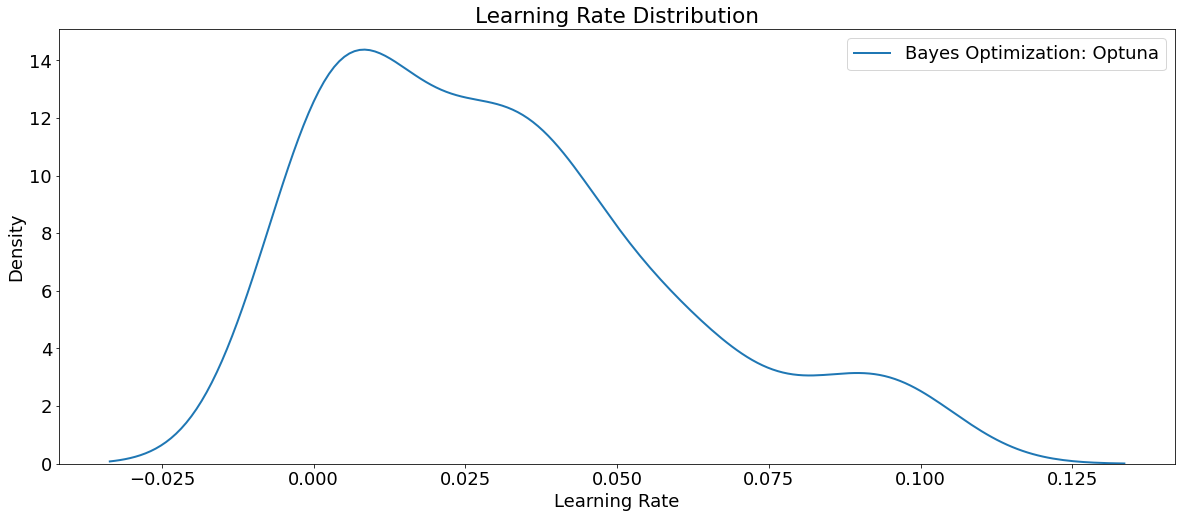

In [ ]:
# Density plots of the learning rate distributions 
plt.figure(figsize=(20,8))
plt.rcParams['font.size'] = 18
sns.kdeplot(trials_df['learning_rate'], label='Bayes Optimization: Optuna', 
            linewidth=2)
plt.legend(loc=1)
plt.xlabel('Learning Rate'); plt.ylabel('Density'); 
plt.title('Learning Rate Distribution');
plt.show()

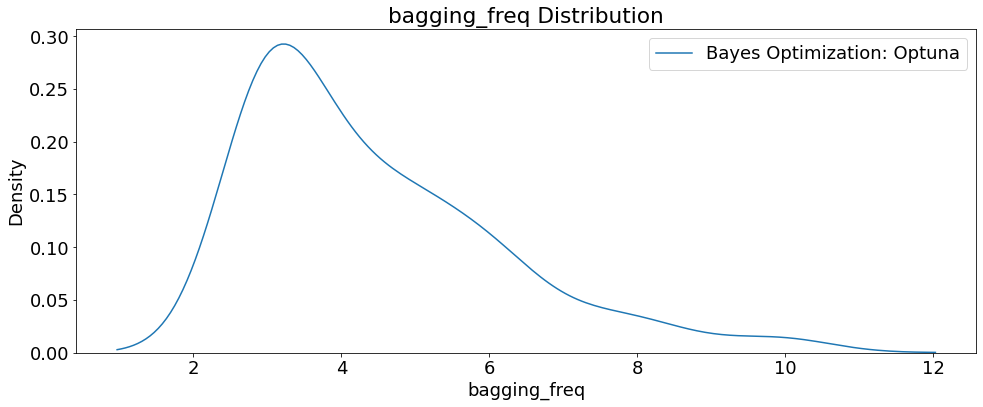

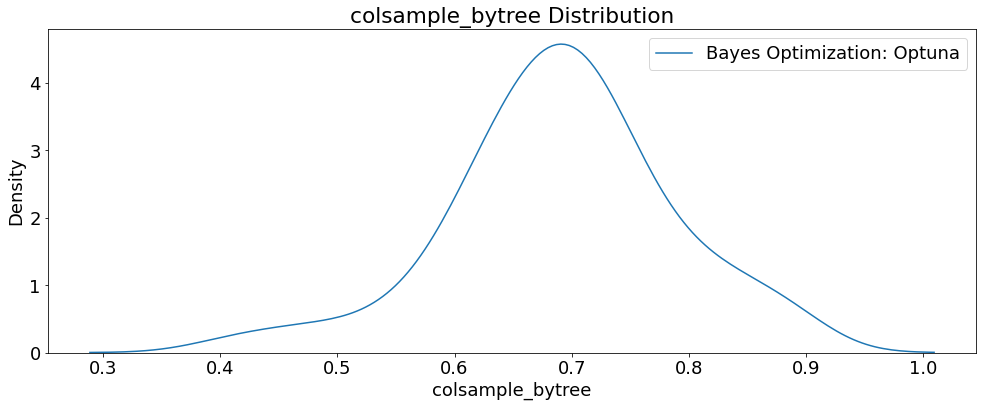

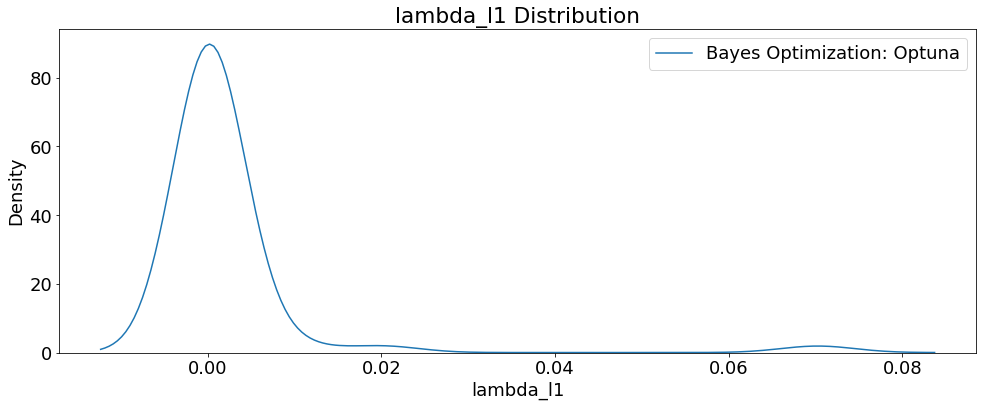

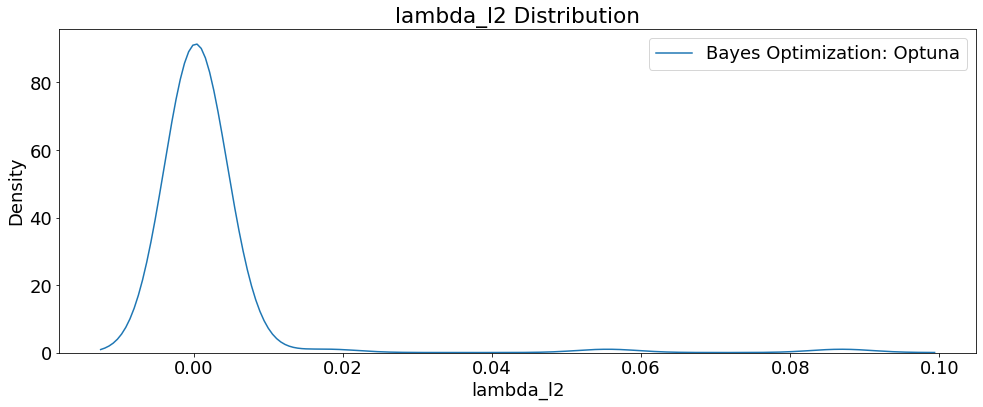

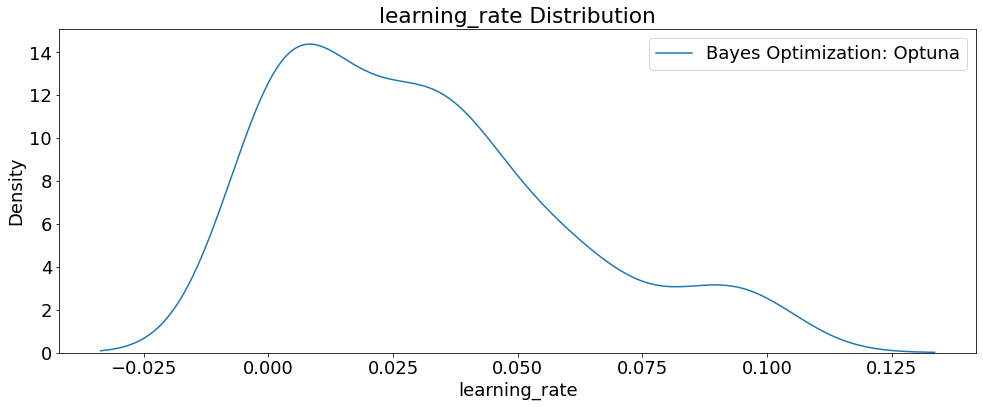

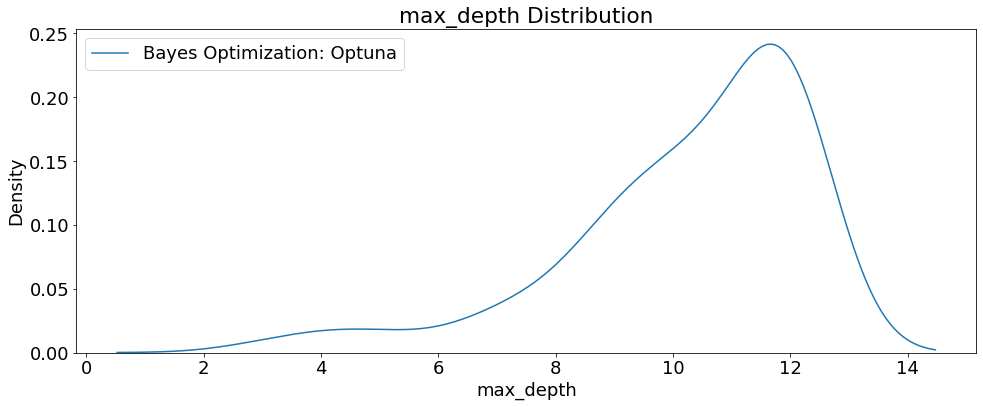

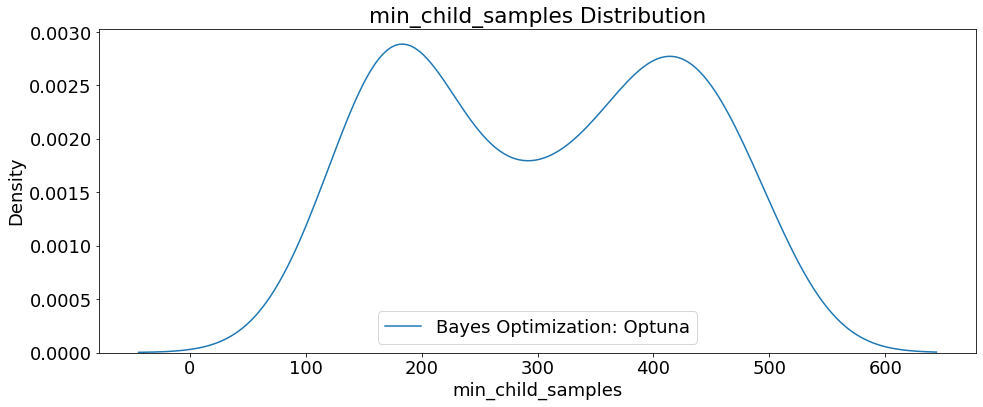

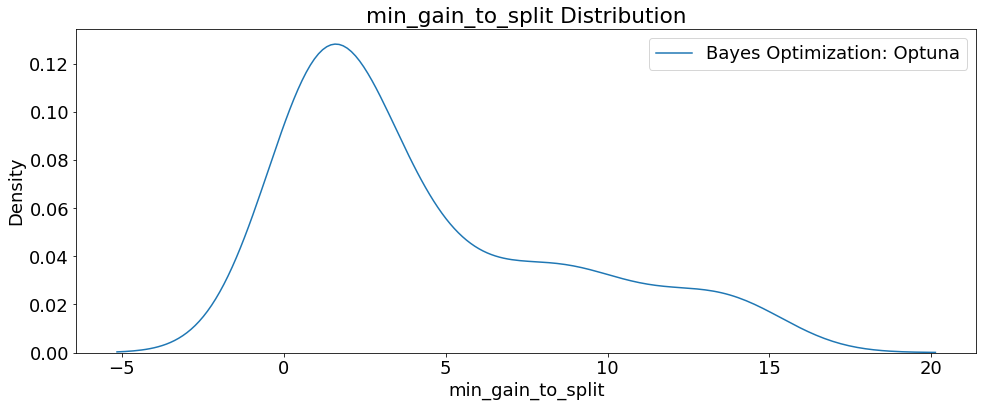

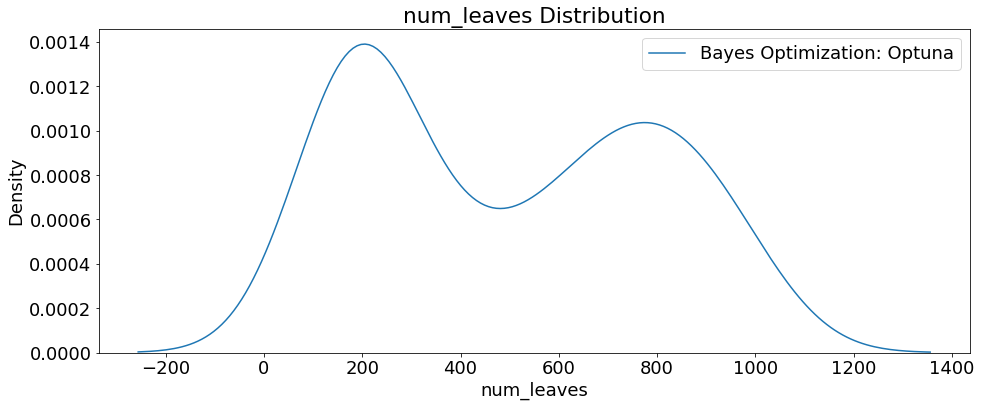

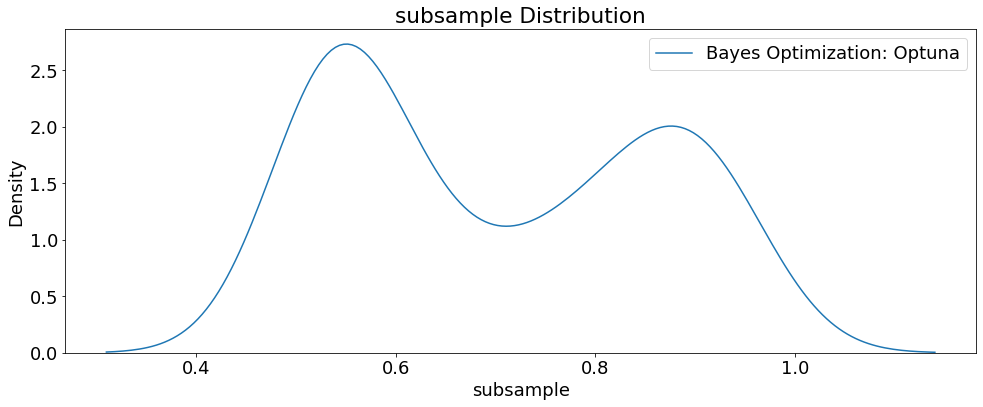

In [ ]:
# Create plots of Hyperparameters that are numeric 
for i, hpo in enumerate(trials_df.columns):
    if hpo not in ['iteration', 'logloss', 'datetime_start', 'datetime_complete',
                   'duration','n_estimators', 'state']:
        plt.figure(figsize=(14,6))
        # Plot the bayes search distribution
        if hpo != 'loss':
            sns.kdeplot(trials_df[hpo], label='Bayes Optimization: Optuna')
            plt.legend(loc=0)
            plt.title('{} Distribution'.format(hpo))
            plt.xlabel('{}'.format(hpo)); plt.ylabel('Density')
            plt.tight_layout()
            plt.show()

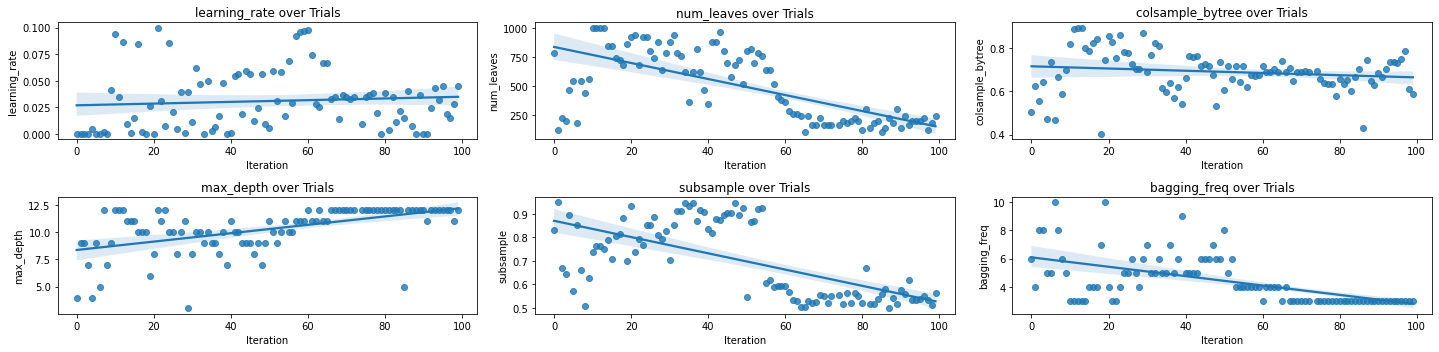

In [ ]:
# Plot quantitative hyperparameters
fig, axs = plt.subplots(2, 3, figsize=(20,5))
i = 0
axs = axs.flatten()
for i, hpo in enumerate(['learning_rate', 'num_leaves', 'colsample_bytree', 
                         'max_depth', 'subsample', 'bagging_freq']):
  # Scatterplot
  sns.regplot('iteration', hpo, data=trials_df, ax=axs[i]) 
  axs[i].set(xlabel='Iteration', ylabel='{}'.format(hpo),  
             title='{} over Trials'.format(hpo))
plt.tight_layout()
plt.show()

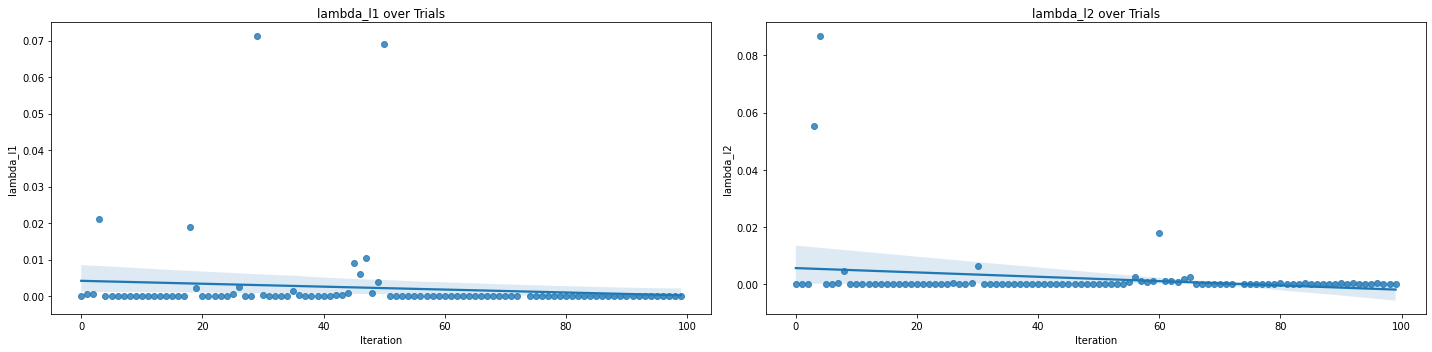

In [ ]:
# Scatterplot of regularization hyperparameters)
fig, axs = plt.subplots(1, 2, figsize=(20,5))
i = 0
for i, hpo in enumerate(['lambda_l1', 'lambda_l2']):
  # Scatterplot
  sns.regplot('iteration', hpo, data=trials_df, ax=axs[i])
  axs[i].set(xlabel='Iteration', ylabel='{}'.format(hpo), 
             title='{} over Trials'.format(hpo))
plt.tight_layout()
plt.show()

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/Yelp_Reviews/Models/ML/lightGBM/ReviewStars/Model_Explanations/

In [ ]:
# Visualize parameter importances
fig = optuna.visualization.plot_param_importances(study)
py.plot(fig, filename='paramImportance_lightGBM_Optuna_100_GPU_balancedSizeSentiment_w2vSentPol.html')
fig.show()

In [ ]:
# Visualize empirical distribution function
fig = optuna.visualization.plot_edf(study)
py.plot(fig, filename='edf_lightGBM_Optuna_100_GPU_balancedSizeSentiment_w2vSentPol.html')
fig.show()

In [ ]:
# Arrange best parameters to fit model for model metrics
params = study.best_params   
params['random_state'] = seed_value
params['metric'] = 'binary_error'
params

{'bagging_freq': 3,
 'colsample_bytree': 0.635285514560008,
 'lambda_l1': 1.3029782119754172e-07,
 'lambda_l2': 0.0002413971452677512,
 'learning_rate': 0.03830194394038319,
 'max_depth': 12,
 'metric': 'binary_error',
 'min_child_samples': 180,
 'min_gain_to_split': 1.5823200718581192,
 'n_estimators': 490,
 'num_leaves': 200,
 'random_state': 42,
 'subsample': 0.5198597730238229}

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/Yelp_Reviews/Models/ML/lightGBM/ReviewStars/Model_PKL/

In [ ]:
# Set up target and features 
label = df[['stars_reviews']]
features = df.cleanReview

# Partition data for train/test 
X_train, X_test, y_train, y_test = train_test_split(features, label,
                                                    test_size=0.2, 
                                                    stratify=label)

In [ ]:
# Vectorize reviews in train/test sets
X_train = pl.fit_transform(X_train)
X_test = pl.fit_transform(X_test)

In [ ]:
# Re-create the best model and train on the training data
best_model = LGBMClassifier(**params, verbosity=-1)

# Fit the model
best_model.fit(X_train, y_train)

# Save model
Pkl_Filename = 'lightGBM_HPO_Optuna_trials100_GPU_balancedSizeSentiment_w2vSentPol.pkl'  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(best_model, file)

# =============================================================================
# # To load saved model
# model = joblib.load('lightGBM_HPO_Optuna_trials100_GPU_balancedSizeSentiment_w2vSentPol.pkl')
# print(model)
# =============================================================================

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



In [ ]:
print('Results from lightGBM HPO Optuna 100 GPU trials:')
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)
print('\n')
print('Classification Report: Train')
clf_rpt = classification_report(y_train, y_train_pred)
print(clf_rpt)
print('\n')
print('Confusion matrix: Train')
print(confusion_matrix(y_train, y_train_pred))
print('\n')
print('Classification Report: Test')
clf_rpt = classification_report(y_test, y_test_pred)
print(clf_rpt)
print('\n')
print('Confusion matrix: Test')
print(confusion_matrix(y_test, y_test_pred))
print('\n')
print('Accuracy score: train: %.3f, test: %.3f' % (
        accuracy_score(y_train, y_train_pred),
        accuracy_score(y_test, y_test_pred)))
print('Precision score: train: %.3f, test: %.3f' % (
        precision_score(y_train, y_train_pred),
        precision_score(y_test, y_test_pred)))
print('Recall score: train: %.3f, test: %.3f' % (
        recall_score(y_train, y_train_pred),
        recall_score(y_test, y_test_pred)))
print('F1 score: train: %.3f, test: %.3f' % (
        f1_score(y_train, y_train_pred),
        f1_score(y_test, y_test_pred)))

Results from lightGBM HPO Optuna 100 GPU trials:


Classification Report: Train
              precision    recall  f1-score   support

         0.0       0.95      0.95      0.95    331950
         1.0       0.95      0.95      0.95    331949

    accuracy                           0.95    663899
   macro avg       0.95      0.95      0.95    663899
weighted avg       0.95      0.95      0.95    663899



Confusion matrix: Train
[[316051  15899]
 [ 16373 315576]]


Classification Report: Test
              precision    recall  f1-score   support

         0.0       0.94      0.94      0.94     82987
         1.0       0.94      0.94      0.94     82988

    accuracy                           0.94    165975
   macro avg       0.94      0.94      0.94    165975
weighted avg       0.94      0.94      0.94    165975



Confusion matrix: Test
[[77929  5058]
 [ 5093 77895]]


Accuracy score: train: 0.951, test: 0.939
Precision score: train: 0.952, test: 0.939
Recall score: train: 0.951, test

In [ ]:
# Evaluate on the testing data 
print('The best model from optimization scores {:.5f} Accuracy on the test set.'.format(accuracy_score(y_test, 
                                                                                                       y_test_pred)))
print('This was achieved using these conditions:')
print(trials_df.iloc[0])

The best model from optimization scores 0.93796 Accuracy on the test set.
This was achieved using these conditions:
iteration                                    77
logloss                                0.157224
datetime_start       2022-05-14 02:04:04.796626
datetime_complete    2022-05-14 02:06:15.787930
duration                 0 days 00:02:10.991304
bagging_freq                                3.0
colsample_bytree                       0.635286
lambda_l1                                   0.0
lambda_l2                              0.000241
learning_rate                          0.038302
max_depth                                  12.0
min_child_samples                         180.0
min_gain_to_split                       1.58232
n_estimators                              490.0
num_leaves                                200.0
subsample                               0.51986
state                                  COMPLETE
Name: 0, dtype: object
The best model from optimization scores 0.937

## GloVe 6B 50d - Reviews: 50epochs

In [ ]:
# Define parameters for Word2Vec model
base_model = Word2Vec(min_count=1, window=5, size=20, workers=cores)

In [ ]:
# Build vocab for model
print('Time to build vocab:', end='')
start = time.time()
base_model.build_vocab(features)
end = time.time()
print(round(end-start, 2), 'seconds')
total_examples = base_model.corpus_count

Time to build vocab:67.12 seconds


In [ ]:
# Set path
%cd /content/drive/MyDrive/Yelp_Reviews/Data/preTrainedModel/

/content/drive/MyDrive/Yelp_Reviews/Data/preTrainedModel


In [ ]:
# Load file with glove
glove_file = ('glove.6B.50d.txt')
tmp_file = get_tmpfile('test_word2vec.txt')
_ = glove2word2vec(glove_file, tmp_file) 

# Import vectors 
glove_vector = KeyedVectors.load_word2vec_format(tmp_file)
base_model.build_vocab([list(glove_vector.vocab.keys())], update=True)

In [ ]:
# Generate Word2Vec Word Embeddings
print('Time to train model:', end=' ')
start = time.time()
base_model.train(features, total_examples=total_examples, epochs=50) 
end = time.time()
print(round(end-start, 2), 'seconds')
base_model_wv = base_model.wv
glove = base_model
glove_wv = base_model.wv

Time to train model: 1702.56 seconds


In [ ]:
%cd /content/drive/MyDrive/Yelp_Reviews/Data/word2vec_models/

/content/drive/MyDrive/Yelp_Reviews/Data/word2vec_models


In [ ]:
# Save the model
wv = glove_wv
glove.wv.save_word2vec_format('glove.6B.50dModel_review125_50epochs_balanced.bin', 
                              binary=True)

In [ ]:
# Load model
word2vec_path = 'glove.6B.50dModel_review125_50epochs_balanced.bin'
model = models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True)
wv = model.wv
pl = Pipeline([('W2vVectorizer', W2vVectorizer(wv))])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning:

Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).



### 100 Trials

In [ ]:
%cd /content/drive/MyDrive/Yelp_Reviews/Models/ML/lightGBM/ReviewStars/Model_PKL/

In [ ]:
# Log into wandb
wandb.login()

wandb_kwargs = {'project': 'YelpReviews_lightGBM_Optuna', 'entity': 'aschultz', 
                'group': 'optuna_lgb100gpu_RS_glove50d', 
                'save_code': 'False', 'notes': 'optuna_lgb100gpu_RS_glove50d'}
wandbc = WeightsAndBiasesCallback(wandb_kwargs=wandb_kwargs, as_multirun=True)

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 

··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: ExperimentalWarning:

WeightsAndBiasesCallback is experimental (supported from v2.9.0). The interface can change in the future.



In [ ]:
# Set up WB callbacks
@wandbc.track_in_wandb()

def lgb_hpo(trial):
    """
    Objective function to tune a `lightGBMClassifier` model.
    """
    joblib.dump(study, 'lightGBM_Optuna_100_GPU_glove50d_balanced.pkl')

    # Define parameter grid
    params_lgb_optuna = {
        'random_state': seed_value,
        'device_type':'gpu',
        'objective': 'binary',
        'metric': 'binary_logloss',
        'boosting_type': 'gbdt',
        'n_estimators': trial.suggest_int('n_estimators', 100, 500, step=10),
        'learning_rate': trial.suggest_float('learning_rate', 1e-6, 0.1),
        'num_leaves': trial.suggest_int('num_leaves', 100, 1000, step=20),
        'bagging_freq': trial.suggest_int('bagging_freq', 3, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 0.95),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 0.9),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 1e-1, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 1e-1,  log=True),
        'min_gain_to_split': trial.suggest_float('min_gain_to_split', 0, 15),
        'min_child_samples': trial.suggest_int('min_child_samples', 100, 500, 
                                               step=10),       
        'verbosity': -1}
    
    # Define model
    model = LGBMClassifier(**params_lgb_optuna, early_stopping_rounds=150)

    return train_model_for_study(features, label, model)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: ExperimentalWarning:

track_in_wandb is experimental (supported from v3.0.0). The interface can change in the future.



In [ ]:
# Begin HPO trials 
# Start timer for experiment
start_time = datetime.now()
print('%-20s %s' % ('Start Time', start_time))
if os.path.isfile('lightGBM_Optuna_100_GPU_glove50d_balanced.pkl'):
    study = joblib.load('lightGBM_Optuna_100_GPU_glove50d_balanced.pkl')
else:
    study = optuna.create_study(direction='minimize')
study.optimize(lgb_hpo, n_trials=100, callbacks=[wandbc])

# End timer for experiment
end_time = datetime.now()
print('%-20s %s' % ('Start Time', start_time))
print('%-20s %s' % ('End Time', end_time))
print(str(timedelta(seconds=(end_time-start_time).seconds)))
print('\n')
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)
print('Lowest LogLoss', study.best_value)
wandb.finish()

wandb: Currently logged in as: aschultz. Use `wandb login --relogin` to force relogin


Start Time           2022-09-05 20:32:30.585373


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.



[LightGBM] [Warning] lambda_l2 is set=2.5746242656274384e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.5746242656274384e-05
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] early_stopping_round is set=150, early_stopping_rounds=150 will be ignored. Current value: early_stopping_round=150
[LightGBM] [Warning] lambda_l1 is set=1.2128213663552513e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2128213663552513e-08
[LightGBM] [Warning] min_gain_to_split is set=1.9471100936506114, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.9471100936506114
- Validation logloss: 0.33299766433595884


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.



- Validation logloss: 0.688354429414281


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.



- Validation logloss: 0.3044337117566019


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.



- Validation logloss: 0.17477061751810952


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.



- Validation logloss: 0.2801029561185276


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.



- Validation logloss: 0.6927101486273571


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.



- Validation logloss: 0.6928600712601881


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.



- Validation logloss: 0.6915944774727757


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.



- Validation logloss: 0.6921967145904895


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.



- Validation logloss: 0.6884559256342424


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.



- Validation logloss: 0.16664196780737234


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.



- Validation logloss: 0.16567800351124207


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.



- Validation logloss: 0.16968825061356202


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.



- Validation logloss: 0.6566128026932735


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.



- Validation logloss: 0.20588318719585022


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.



- Validation logloss: 0.5939136154656025


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.



- Validation logloss: 0.22039467429574197


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.



- Validation logloss: 0.6716220875543661


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.



- Validation logloss: 0.5569817764036338


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.



- Validation logloss: 0.17091458648366956


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.



- Validation logloss: 0.1616941353736356


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.



- Validation logloss: 0.1618124532243107


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.



- Validation logloss: 0.18430304781019438


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.



- Validation logloss: 0.16148484522984136


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.



- Validation logloss: 0.16615030687316804


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.



- Validation logloss: 0.4831305438286512


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.



- Validation logloss: 0.21203301900423216


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.



- Validation logloss: 0.16375988443002945


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.



- Validation logloss: 0.6609474449562251


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.



- Validation logloss: 0.40472087578378807


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.



- Validation logloss: 0.19924230397038106


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.



- Validation logloss: 0.16216668804930068


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.



- Validation logloss: 0.16093955176481736


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.



- Validation logloss: 0.16059726224886509


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.



- Validation logloss: 0.16079081351540436


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.



- Validation logloss: 0.32212820430508343


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.



- Validation logloss: 0.1596762908159506


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.



- Validation logloss: 0.22933598855331697


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.



- Validation logloss: 0.15874444011092406


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.



- Validation logloss: 0.1676001642185259


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.



- Validation logloss: 0.6822340310703998


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.



- Validation logloss: 0.16018825811322127


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.



- Validation logloss: 0.16002158008401476


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.



- Validation logloss: 0.1621085821960179


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.



- Validation logloss: 0.17695182937324747


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.



- Validation logloss: 0.2315568575515483


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.



- Validation logloss: 0.1592523623706876


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.



- Validation logloss: 0.16046113368074402


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.



- Validation logloss: 0.1689163681056546


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.



- Validation logloss: 0.5128038032755369


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.



- Validation logloss: 0.16552688944324231


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.



- Validation logloss: 0.1589195034477695


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.



- Validation logloss: 0.1600116587897574


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.



- Validation logloss: 0.15942990691368472


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.



- Validation logloss: 0.1587347494973106


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.



- Validation logloss: 0.2127461924068933


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.



- Validation logloss: 0.6899069836436859


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.



- Validation logloss: 0.16677911145341592


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.



- Validation logloss: 0.15950238695708685


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.



- Validation logloss: 0.15888816625644062


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.



- Validation logloss: 0.15866257339409165


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.



- Validation logloss: 0.15776942278610231


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.



- Validation logloss: 0.16028095945765689


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.



- Validation logloss: 0.15825687937322155


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.



- Validation logloss: 0.15828132936424472


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.



- Validation logloss: 0.15640519959972007


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.



- Validation logloss: 0.6928027242386544


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.



- Validation logloss: 0.15795081314812426


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.



- Validation logloss: 0.15811300812286885


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.



- Validation logloss: 0.15831718077710447


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.



- Validation logloss: 0.15839539584373444


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.



- Validation logloss: 0.15800580565561084


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.



- Validation logloss: 0.15814330626112122


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.



- Validation logloss: 0.15874268385098028


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.



- Validation logloss: 0.15889737689073566


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.



- Validation logloss: 0.15817079001880352


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.



- Validation logloss: 0.1585273419543174


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.



- Validation logloss: 0.15894649133695304


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.



- Validation logloss: 0.1584078667338523


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.



- Validation logloss: 0.15972347168960488


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.



- Validation logloss: 0.1588017550197478


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.



- Validation logloss: 0.15940932373674574


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.



- Validation logloss: 0.1580455165274947


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.



- Validation logloss: 0.17829933135445017


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.



- Validation logloss: 0.16186013341810992


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.



- Validation logloss: 0.15722514667472684


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.



- Validation logloss: 0.16254132934617346


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.



- Validation logloss: 0.6327513510812818


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.



- Validation logloss: 0.22438416516171272


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.



- Validation logloss: 0.15859629661650937


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.



- Validation logloss: 0.23821551442921124


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.



- Validation logloss: 0.15911728815380888


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.



- Validation logloss: 0.1574428092602038


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.



- Validation logloss: 0.15810183672170156


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.



- Validation logloss: 0.15774115243181214


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.



- Validation logloss: 0.15810173101197214


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.



- Validation logloss: 0.15816190600498942


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.



- Validation logloss: 0.15835583965606292


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.



- Validation logloss: 0.16201029388933258


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.



- Validation logloss: 0.6925452706457752


Start Time           2022-09-05 20:32:30.585373
End Time             2022-09-06 01:04:52.966473
4:32:22


Number of finished trials: 100
Best trial: {'n_estimators': 420, 'learning_rate': 0.06526365998387267, 'num_leaves': 560, 'bagging_freq': 3, 'subsample': 0.6543791316601429, 'colsample_bytree': 0.8216955232742138, 'max_depth': 11, 'lambda_l1': 4.302110730867281e-06, 'lambda_l2': 1.813117920454269e-06, 'min_gain_to_split': 1.1709960855188997, 'min_child_samples': 330}
Lowest LogLoss 0.15640519959972007


In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/Yelp_Reviews/Models/ML/lightGBM/ReviewStars/trialOptions/

In [ ]:
# Output from HPO trials
trials_df = study.trials_dataframe()
trials_df.rename(columns={'number': 'iteration'}, inplace=True)
trials_df.rename(columns={'value': 'logloss'},inplace=True)
trials_df.rename(columns={'params_bagging_freq': 'bagging_freq'}, inplace=True)
trials_df.rename(columns={'params_colsample_bytree': 'colsample_bytree'}, 
                 inplace=True)
trials_df.rename(columns={'params_lambda_l1': 'lambda_l1'}, inplace=True)
trials_df.rename(columns={'params_lambda_l2': 'lambda_l2'}, inplace=True)
trials_df.rename(columns={'params_learning_rate': 'learning_rate'}, 
                 inplace=True)
trials_df.rename(columns={'params_max_depth': 'max_depth'}, inplace=True)
trials_df.rename(columns={'params_min_child_samples': 'min_child_samples'}, 
                 inplace=True)
trials_df.rename(columns={'params_min_gain_to_split': 'min_gain_to_split'}, 
                 inplace=True)
trials_df.rename(columns={'params_n_estimators': 'n_estimators'}, inplace=True)
trials_df.rename(columns={'params_num_leaves': 'num_leaves'}, inplace=True)
trials_df.rename(columns={'params_subsample': 'subsample'}, inplace=True)
trials_df = trials_df.sort_values('logloss', ascending=True)
trials_df = trials_df[trials_df['logloss'].notna()]
print(trials_df) 

# Write processed data to csv
trials_df.to_csv('lightGBM_Optuna_100_GPU_glove50d_balanced.csv', index=False)

    iteration   logloss             datetime_start          datetime_complete  \
65         65  0.156405 2022-09-05 23:31:08.404582 2022-09-05 23:34:09.350542   
85         85  0.157225 2022-09-06 00:24:32.218202 2022-09-06 00:27:14.937296   
92         92  0.157443 2022-09-06 00:43:03.600662 2022-09-06 00:45:37.700719   
94         94  0.157741 2022-09-06 00:48:21.654773 2022-09-06 00:51:00.227267   
61         61  0.157769 2022-09-05 23:19:04.419536 2022-09-05 23:22:12.044260   
..        ...       ...                        ...                        ...   
8           8  0.692197 2022-09-05 20:52:58.222615 2022-09-05 20:55:19.204079   
99         99  0.692545 2022-09-06 01:02:21.328550 2022-09-06 01:04:46.390882   
5           5  0.692710 2022-09-05 20:45:20.445621 2022-09-05 20:47:55.869719   
66         66  0.692803 2022-09-05 23:34:14.645539 2022-09-05 23:37:19.878317   
6           6  0.692860 2022-09-05 20:48:02.267823 2022-09-05 20:50:20.549656   

                 duration  

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/Yelp_Reviews/Models/ML/lightGBM/ReviewStars/Model_Explanations/

In [ ]:
# Plot_optimization_history: shows the scores from all trials as well as the best score so far at each point.
fig = optuna.visualization.plot_optimization_history(study)
py.plot(fig, filename='optimizationHistory_lightGBM_Optuna_100_GPU_glove50d_balanced.html')
fig.show()

In [ ]:
# plot_parallel_coordinate: interactively visualizes the hyperparameters and scores
fig = optuna.visualization.plot_parallel_coordinate(study)
py.plot(fig, filename='parallelCoordinate_lightGBM_Optuna_100_GPU_glove50d_balanced.html')
fig.show()

In [ ]:
# plot_slice: shows the change of the hyperparamters space over the search. 
fig = optuna.visualization.plot_slice(study)
py.plot(fig, filename='slice_lightGBM_Optuna_100_GPU_glove50d_balanced.html')
fig.show()

In [ ]:
# plot_contour: plots parameter interactions on an interactive chart. You can choose which hyperparameters you would like to explore.
fig = optuna.visualization.plot_contour(study, params=['num_leaves', 
                                                       'max_depth', 
                                                       'subsample', 
                                                       'learning_rate'])
py.plot(fig, filename='contour_lightGBM_Optuna_100_GPU_glove50d_balanced.html')
fig.show()

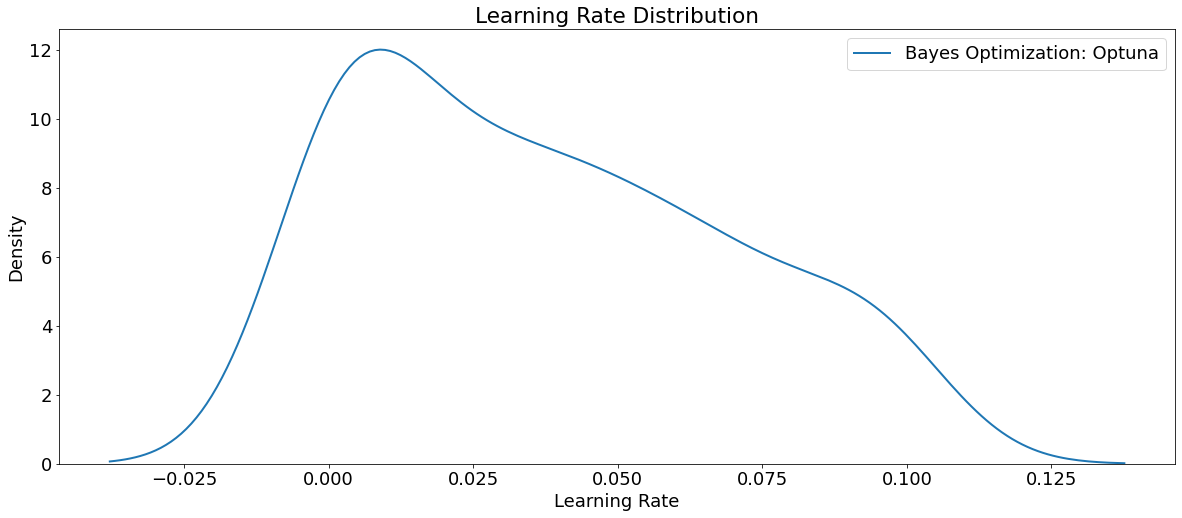

In [ ]:
# Density plots of the learning rate distributions 
plt.figure(figsize=(20,8))
plt.rcParams['font.size'] = 18
sns.kdeplot(trials_df['learning_rate'], label='Bayes Optimization: Optuna', 
            linewidth=2)
plt.legend(loc=1)
plt.xlabel('Learning Rate'); plt.ylabel('Density'); 
plt.title('Learning Rate Distribution');
plt.show()

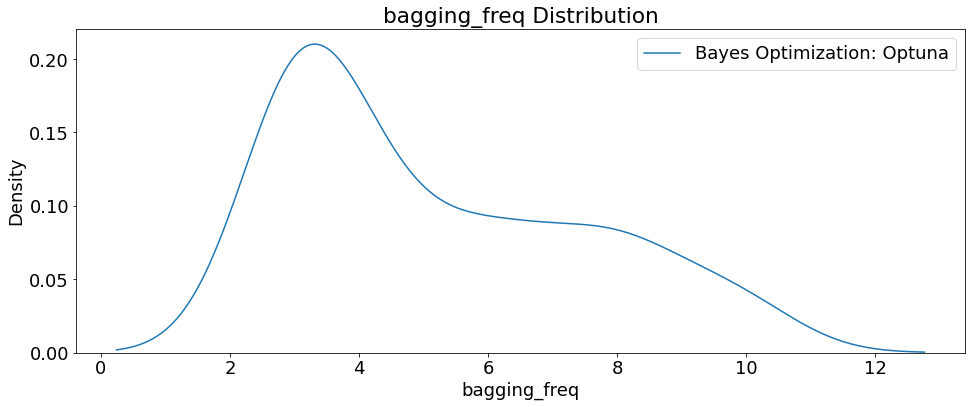

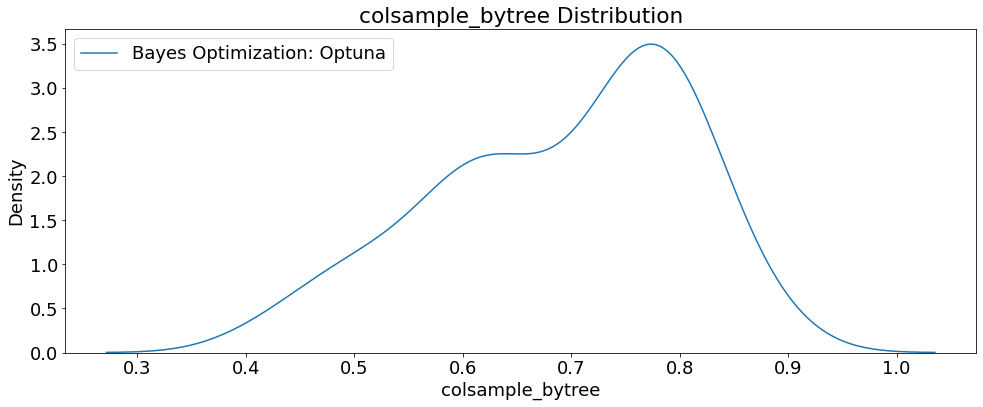

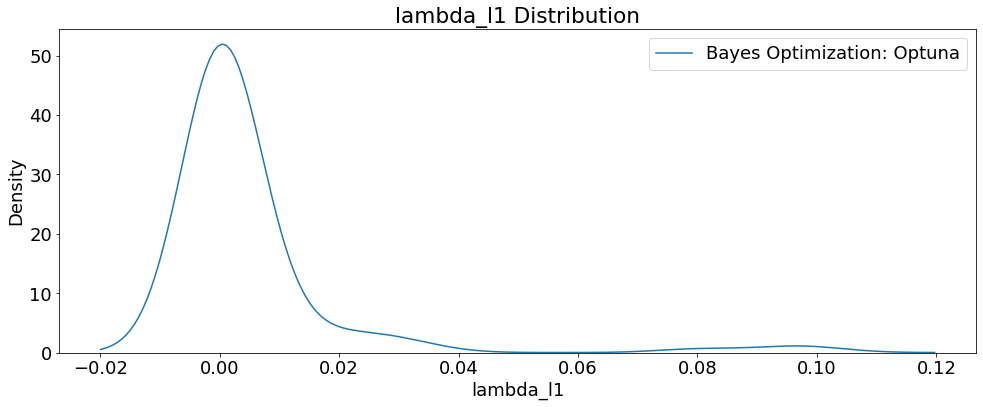

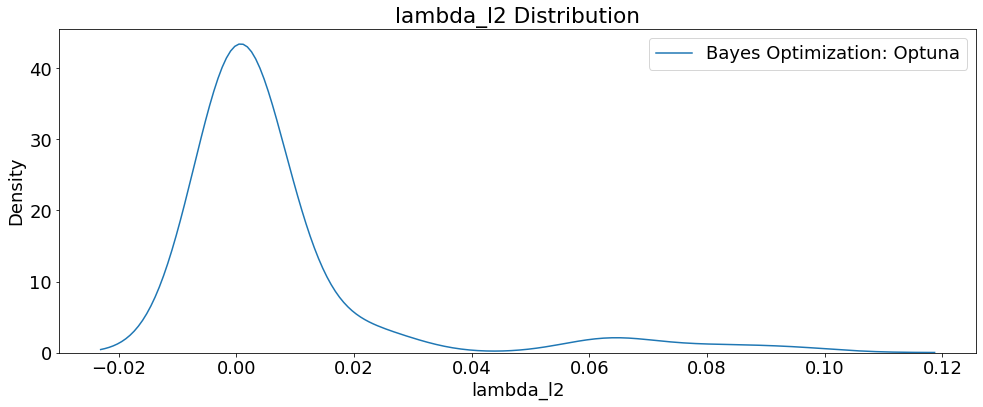

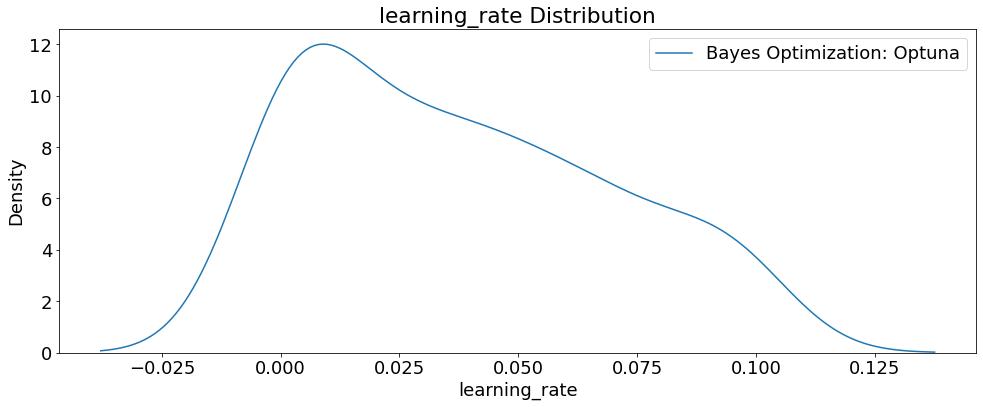

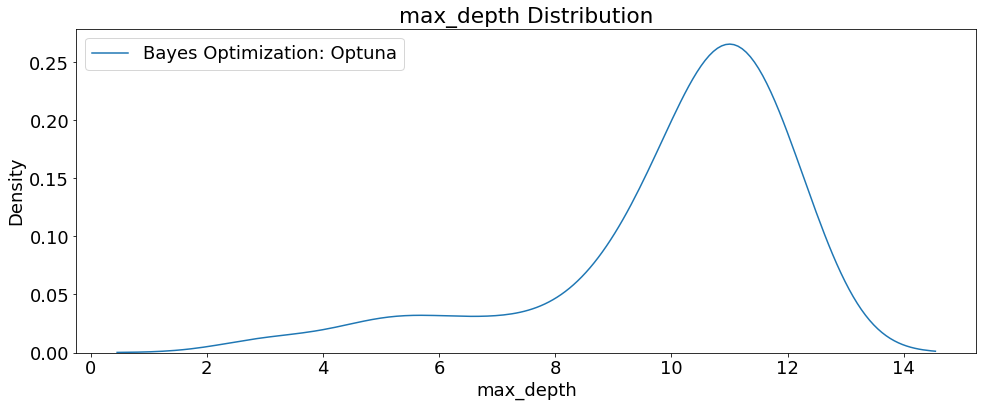

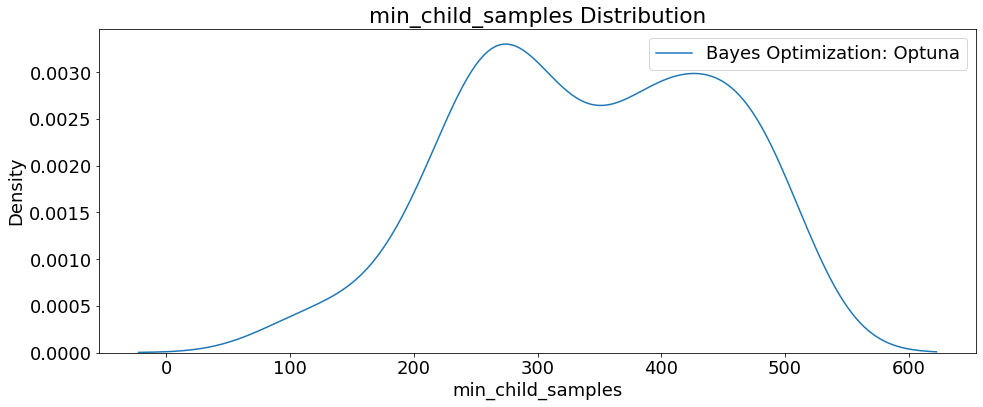

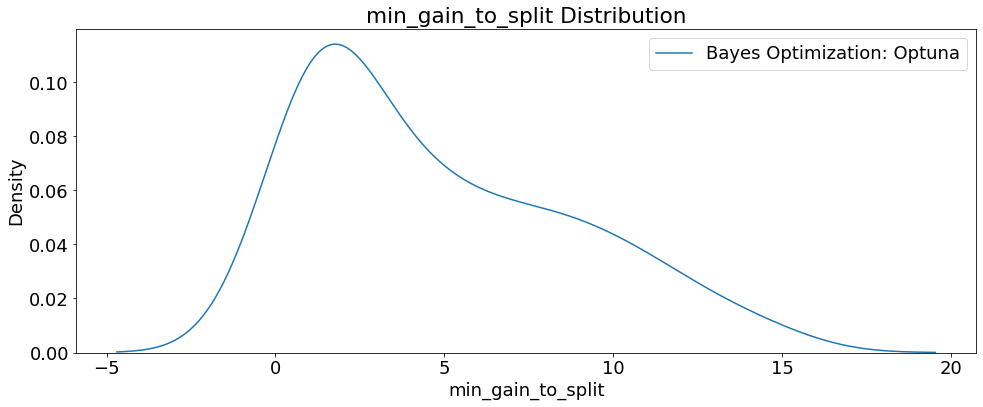

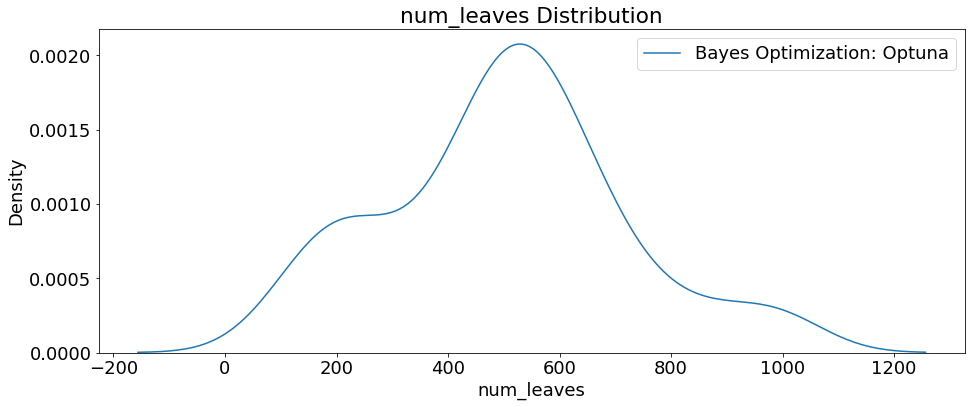

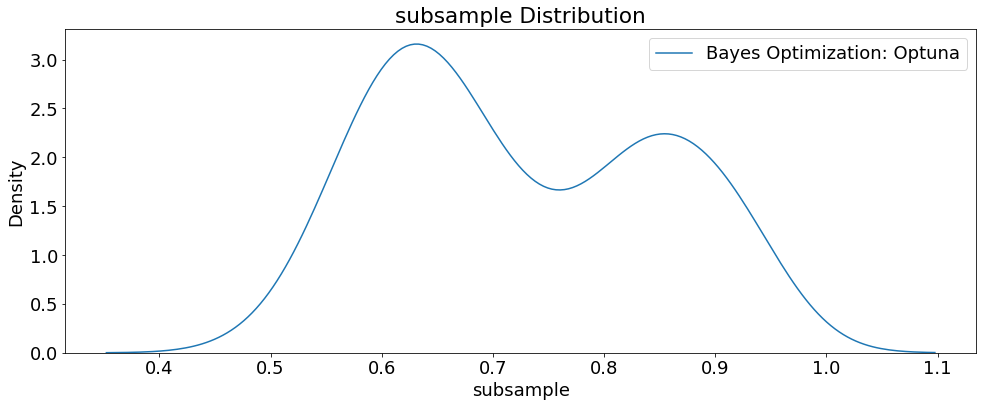

In [ ]:
# Create plots of Hyperparameters that are numeric 
for i, hpo in enumerate(trials_df.columns):
    if hpo not in ['iteration', 'logloss', 'datetime_start', 'datetime_complete',
                   'duration','n_estimators', 'state']:
        plt.figure(figsize=(14,6))
        # Plot the bayes search distribution
        if hpo != 'loss':
            sns.kdeplot(trials_df[hpo], label='Bayes Optimization: Optuna')
            plt.legend(loc=0)
            plt.title('{} Distribution'.format(hpo))
            plt.xlabel('{}'.format(hpo)); plt.ylabel('Density')
            plt.tight_layout()
            plt.show()

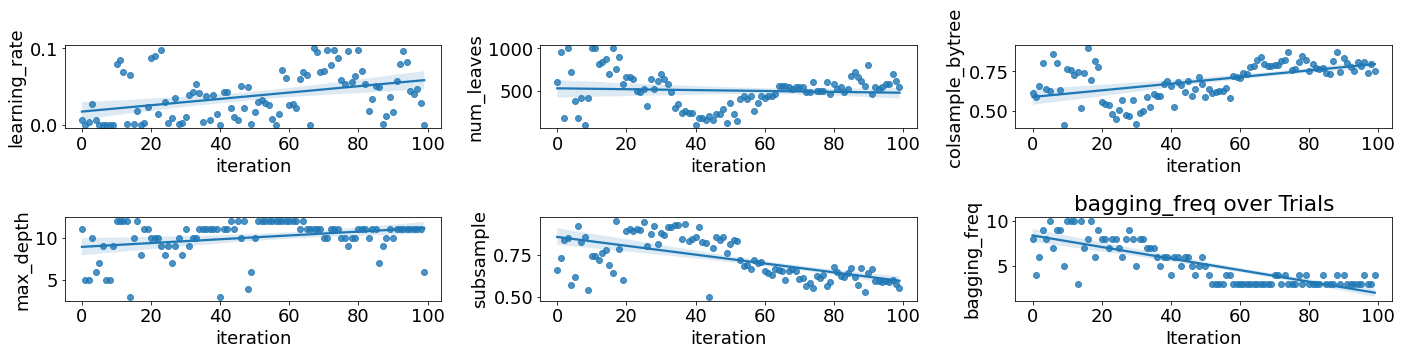

In [ ]:
# Plot quantitive hyperparameters
fig, axs = plt.subplots(2, 3, figsize=(20,5))
i = 0
axs = axs.flatten()
for i, hpo in enumerate(['learning_rate', 'num_leaves', 'colsample_bytree', 
                         'max_depth', 'subsample', 'bagging_freq']):
  # Scatterplot
  sns.regplot('iteration', hpo, data=trials_df, ax=axs[i]) 
  axs[i].set(xlabel='Iteration', ylabel='{}'.format(hpo),  
             title='{} over Trials'.format(hpo))
plt.tight_layout()
plt.show()

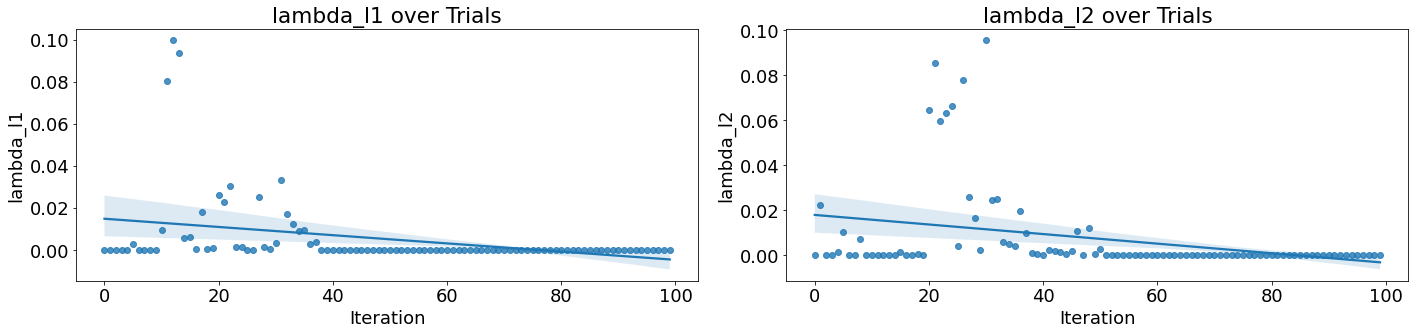

In [ ]:
# Scatterplot of regularization hyperparameters)
fig, axs = plt.subplots(1, 2, figsize=(20,5))
i = 0
for i, hpo in enumerate(['lambda_l1', 'lambda_l2']):
  # Scatterplot
  sns.regplot('iteration', hpo, data=trials_df, ax=axs[i])
  axs[i].set(xlabel='Iteration', ylabel='{}'.format(hpo), 
             title='{} over Trials'.format(hpo))
plt.tight_layout()
plt.show()

In [ ]:
# Visualize parameter importances
fig = optuna.visualization.plot_param_importances(study)
py.plot(fig, filename='paramImportance_lightGBM_Optuna_100_GPU_glove50d_balanced.html')
fig.show()

In [ ]:
# Visualize empirical distribution function
fig = optuna.visualization.plot_edf(study)
py.plot(fig, filename='edf_lightGBM_Optuna_100_GPU_glove50d_balanced.html')
fig.show()

In [ ]:
# Arrange best parameters to fit model for model metrics
params = study.best_params   
params['random_state'] = seed_value
params['metric'] = 'binary_error'
params

{'n_estimators': 420,
 'learning_rate': 0.06526365998387267,
 'num_leaves': 560,
 'bagging_freq': 3,
 'subsample': 0.6543791316601429,
 'colsample_bytree': 0.8216955232742138,
 'max_depth': 11,
 'lambda_l1': 4.302110730867281e-06,
 'lambda_l2': 1.813117920454269e-06,
 'min_gain_to_split': 1.1709960855188997,
 'min_child_samples': 330,
 'random_state': 42,
 'metric': 'binary_error'}

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/Yelp_Reviews/Models/ML/lightGBM/ReviewStars/Model_PKL/

In [ ]:
# Set up label and features
label = df[['stars_reviews']]
features = df.cleanReview

# Partition data for train/test 
X_train, X_test, y_train, y_test = train_test_split(features, label,
                                                    test_size=0.2, 
                                                    stratify=label)

In [ ]:
# Vectorize reviews in train/test sets
X_train = pl.fit_transform(X_train)
X_test = pl.fit_transform(X_test)

In [ ]:
# Re-create the best model and train on the training data
best_model = LGBMClassifier(**params, verbosity=-1)

# Fit the model
best_model.fit(X_train, y_train.values.ravel())

# Save model
Pkl_Filename = 'lightGBM_HPO_Optuna_trials100_GPU_glove50d_balanced.pkl'  

with open(Pkl_Filename, 'wb') as file:  
     pickle.dump(best_model, file)

# =============================================================================
# # To load saved model
# model = joblib.load('lightGBM_HPO_Optuna_trials100_GPU_glove50d_balanced.pkl')
# print(model)
# =============================================================================

In [ ]:
print('Results from lightGBM HPO Optuna 100 GloVe GPU trials:')
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)
print('\n')
print('Classification Report: Train')
clf_rpt = classification_report(y_train, y_train_pred)
print(clf_rpt)
print('\n')
print('Confusion matrix: Train')
print(confusion_matrix(y_train, y_train_pred))
print('\n')
print('Classification Report: Test')
clf_rpt = classification_report(y_test, y_test_pred)
print(clf_rpt)
print('\n')
print('Confusion matrix: Test')
print(confusion_matrix(y_test, y_test_pred))
print('\n')
print('Accuracy score: train: %.3f, test: %.3f' % (
        accuracy_score(y_train, y_train_pred),
        accuracy_score(y_test, y_test_pred)))
print('Precision score: train: %.3f, test: %.3f' % (
        precision_score(y_train, y_train_pred),
        precision_score(y_test, y_test_pred)))
print('Recall score: train: %.3f, test: %.3f' % (
        recall_score(y_train, y_train_pred),
        recall_score(y_test, y_test_pred)))
print('F1 score: train: %.3f, test: %.3f' % (
        f1_score(y_train, y_train_pred),
        f1_score(y_test, y_test_pred)))

Results from lightGBM HPO Optuna 100 GloVe GPU trials:


Classification Report: Train
              precision    recall  f1-score   support

         0.0       0.96      0.96      0.96    331950
         1.0       0.96      0.96      0.96    331949

    accuracy                           0.96    663899
   macro avg       0.96      0.96      0.96    663899
weighted avg       0.96      0.96      0.96    663899



Confusion matrix: Train
[[318920  13030]
 [ 13786 318163]]


Classification Report: Test
              precision    recall  f1-score   support

         0.0       0.94      0.94      0.94     82987
         1.0       0.94      0.94      0.94     82988

    accuracy                           0.94    165975
   macro avg       0.94      0.94      0.94    165975
weighted avg       0.94      0.94      0.94    165975



Confusion matrix: Test
[[78022  4965]
 [ 5199 77789]]


Accuracy score: train: 0.960, test: 0.939
Precision score: train: 0.961, test: 0.940
Recall score: train: 0.958

In [ ]:
# Evaluate on the testing data 
print('The best model from optimization scores {:.5f} Accuracy on the test set.'.format(accuracy_score(y_test, 
                                                                                                       y_test_pred)))
print('This was achieved using these conditions:')
print(trials_df.iloc[0])

The best model from optimization scores 0.93876 Accuracy on the test set.
This was achieved using these conditions:
iteration                                    65
logloss                                0.156405
datetime_start       2022-09-05 23:31:08.404582
datetime_complete    2022-09-05 23:34:09.350542
duration                 0 days 00:03:00.945960
bagging_freq                                  3
colsample_bytree                       0.821696
lambda_l1                              0.000004
lambda_l2                              0.000002
learning_rate                          0.065264
max_depth                                    11
min_child_samples                           330
min_gain_to_split                      1.170996
n_estimators                                420
num_leaves                                  560
subsample                              0.654379
state                                  COMPLETE
Name: 65, dtype: object
